In [1]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane import AngleEmbedding, AmplitudeEmbedding


In [2]:
# U='U_TTN'
# U_p=2
# U='U_9'
# U_p=2
# U='U_15'
# U_p=4
# U='U_13'
# U_p=6
# U='U_14'
# U_p=6
U='U_SO4'
U_p=6
# U='U_5'
# U_p=10
# U='U_6'
# U_p=10
# U='U_SU4'
# U_p=15

totol_params=2*U_p+2


torch.manual_seed(42)
np.random.seed(42)


os.environ["OMP_NUM_THREADS"] = "1"

step = 0.003               # Learning rate
batch_size = 32              # Number of samples for each training step
num_epochs = 50              # Number of training epochs

gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

train_all_loss=[]
train_all_acc=[]
val_all_loss=[]
val_all_acc=[]
best_accuracy=0

device = torch.device("cpu")

In [3]:
train_f=[[48, 154, 169, 186, 237, 272, 493, 564, 565, 641, 645, 1013, 1158, 1308, 1327, 1479, 1489, 1525, 1526, 1707, 1727, 1846, 1912, 2289, 2310, 2315, 2402, 2471, 2601, 2809, 2975, 3089, 3326, 3345, 3472, 3499, 3592, 3637, 3679, 3864, 4085, 4234, 4274, 4389, 4455, 4461, 4544, 4712, 4766, 4932, 4971, 5402, 5439, 5702, 5728, 5733, 5737, 5758, 5894, 5994, 6078, 6165, 6309, 6390, 6544, 6592, 6623, 6653, 6678, 6746, 6753, 6822, 7201, 7202, 7306, 7360, 7374, 7457, 7499, 7567, 7655, 7680, 7725, 7734, 7848, 7958, 8057, 8060, 8105, 8363, 8637, 8672, 8689, 8697, 8701, 8718, 8733, 8896, 9142, 9374, 9410, 9437, 9579, 9706, 9742, 9778, 9792, 10027, 10181, 10230, 10300, 10412, 10430, 10463, 10552, 10620, 10725, 10768, 11016, 11131, 11228, 11231, 11327, 11460, 11511, 11534, 11739, 11795, 11837, 11916, 12185, 12237, 12277, 12431, 12565, 12630, 12683, 12693, 12856, 12920, 12929, 13110, 13176, 13359, 13950, 14199, 14241, 14307, 14313, 14368, 14382, 14455, 14583, 14627, 14758, 15052, 15119, 15155, 15164, 15183, 15198, 15222, 15260, 15622, 16042, 16207, 16490, 16532, 16541, 16654, 16742, 16814, 16857, 16864, 16927, 16933, 16965, 17263, 17283, 17404, 17430, 17515, 17524, 17560, 17657, 17722, 17993, 18050, 18222, 18243, 18271, 18274, 18283, 18351, 18353, 18461, 18713, 19012, 19137, 19139, 19181, 19296, 19417, 19419, 19532, 19765, 19833, 19856, 19930, 20019, 20039, 20068, 20102, 20136, 20151, 20422, 20771, 20795, 20855, 21143, 21191, 21253, 21319, 21483, 21578, 21589, 21737, 21751, 21949, 21981, 22200, 22371, 22417, 22516, 22552, 22600, 22643, 22685, 22709, 22744, 22753, 22796, 22873, 23058, 23117, 23204, 23299, 23426, 23547, 23660, 23682, 23715, 23829, 23990, 24125, 24178, 24198, 24337, 24628, 24651, 24782, 24831, 24963, 25042, 25055, 25079, 25090, 25228, 25258, 25261, 25287, 25291, 25434, 25911, 25946, 26243, 26293, 26482, 26583, 26663, 26994, 27024, 27070, 27139, 27224, 27615, 27647, 27668, 27680, 27901, 27951, 28002, 28062, 28238, 28451, 28688, 28706, 28762, 28823, 28889, 29031, 29212, 29287, 29292, 29456, 29484, 29597, 29606, 29685, 29862, 29892, 30219, 30256, 30280, 30409, 30453, 30725, 30976, 31093, 31123, 31186, 31269, 31350, 31493, 31546, 31611, 31633, 31649, 31708, 31932, 32111, 32121, 32176, 32230, 32456, 32594, 32766, 32965, 32990, 33025, 33047, 33080, 33114, 33266, 33271, 33364, 33484, 33490, 33609, 33883, 33893, 34169, 34221, 34275, 34342, 34509, 34633, 34674, 34727, 34746, 34882, 35040, 35063, 35100, 35109, 35287, 35310, 35416, 35602, 35688, 35704, 35838, 35933, 35968, 36047, 36081, 36157, 36323, 36336, 36389, 36396, 36490, 36536, 36662, 36725, 36814, 36978, 37036, 37088, 37198, 37233, 37347, 37379, 37439, 37816, 37976, 38069, 38225, 38328, 38348, 38539, 38563, 38569, 38622, 38746, 39044, 39056, 39060, 39128, 39129, 39250, 39330, 39573, 39576, 39663, 39760, 39939, 39979, 40007, 40013, 40074, 40105, 40329, 40333, 40366, 40393, 40518, 40552, 41005, 41181, 41297, 41627, 41894, 41963, 42059, 42066, 42112, 42320, 42394, 43134, 43151, 43240, 43703, 43931, 44004, 44052, 44282, 44360, 44381, 44550, 44561, 44676, 44689, 44769, 44825, 44857, 44947, 45080, 45109, 45112, 45308, 45611, 45647, 45664, 45878, 46285, 46422, 46425, 46462, 46498, 46499, 46661, 46680, 46690, 46863, 46926, 47096, 47125, 47185, 47201, 47272, 47495, 47542, 47551, 47777, 47975, 48150, 48178, 48361, 48378, 48500, 48523, 48638, 48661, 48676, 48734, 48770, 48837, 48897, 48915, 48943, 48998, 49018, 49019, 49288, 49630, 49766, 49767, 49987, 50003, 50247, 50251, 50310, 50324, 50393, 50524, 51119, 51138, 51228, 51425, 51677, 51780, 51792, 52099, 52115, 52194, 52303, 52745, 52761, 52931, 52981, 53018, 53078, 53134, 53399, 53542, 53702, 53791, 53964, 54031, 54123, 54278, 54328, 54454, 54772, 54818, 54845, 54880, 54952, 55113, 55116, 55157, 55196, 55274, 55407, 55450, 55452, 55466, 55506, 55513, 55620, 55707, 55728, 55868, 55906, 55977, 56018, 56205, 56239, 56243, 56271, 56557, 56575, 56663, 57031, 57073, 57180, 57387, 57438, 57766, 57898, 57996, 58022, 58042, 58184, 58416, 58419, 58783, 58813, 59162, 59236, 59248, 59319, 59373, 59434, 59654, 59749, 59769, 59802, 59905], [98, 106, 166, 330, 704, 740, 872, 1102, 1139, 1161, 1508, 1534, 1548, 1631, 1706, 1708, 1901, 1922, 1977, 2076, 2145, 2325, 2518, 2557, 2651, 2664, 2684, 2808, 2981, 3100, 3125, 3329, 3400, 3473, 3475, 3724, 3799, 3861, 3878, 3890, 3930, 3995, 4047, 4066, 4218, 4349, 4609, 4717, 4726, 4767, 4855, 4939, 4951, 4983, 5024, 5061, 5107, 5173, 5348, 5386, 5405, 5411, 5479, 5762, 5890, 5909, 6179, 6243, 6325, 6606, 6617, 6734, 6850, 6869, 6885, 6917, 7020, 7152, 7433, 7437, 7451, 7540, 7652, 7912, 8162, 8575, 8620, 8631, 8634, 8645, 8808, 8899, 9182, 9330, 9486, 9596, 9730, 9779, 9858, 9912, 9953, 10016, 10057, 10063, 10383, 10395, 10501, 10576, 10594, 10634, 10730, 10839, 10951, 10980, 11008, 11035, 11045, 11049, 11080, 11184, 11582, 12029, 12115, 12248, 12575, 12615, 12826, 13033, 13044, 13079, 13080, 13111, 13295, 13325, 13382, 13488, 13626, 13819, 13927, 14093, 14373, 14540, 14644, 14727, 14853, 15142, 15242, 15285, 15322, 15326, 15351, 15463, 15801, 15889, 15984, 15996, 16032, 16127, 16296, 16314, 16321, 16329, 16380, 16620, 16700, 17081, 17245, 17323, 17400, 17446, 17797, 17959, 18294, 18388, 18455, 18498, 18500, 18802, 18937, 18958, 19022, 19029, 19064, 19103, 19206, 19226, 19496, 19629, 19640, 19748, 19808, 19880, 19927, 19979, 20031, 20309, 20781, 20804, 20812, 20813, 20819, 20824, 20868, 20905, 21035, 21579, 21882, 22177, 22284, 22300, 22324, 22332, 22376, 22452, 22557, 22620, 22802, 22869, 22914, 22930, 22966, 22968, 23062, 23263, 23264, 23342, 23369, 23403, 23498, 23543, 23627, 23861, 23875, 24068, 24106, 24187, 24303, 24365, 24375, 24573, 24946, 25267, 25426, 25468, 25520, 25680, 25682, 25871, 25894, 25943, 26055, 26163, 26254, 26291, 26412, 26413, 26499, 26652, 26680, 26943, 26958, 27100, 27162, 27436, 27451, 27504, 27514, 27544, 27548, 27789, 27907, 27968, 28172, 28176, 28197, 28403, 28605, 28755, 28938, 28956, 29117, 29635, 29752, 29774, 29790, 29901, 29937, 29962, 30019, 30031, 30122, 30134, 30199, 30434, 30549, 30589, 30615, 30735, 30737, 30916, 30970, 31117, 31191, 31194, 31309, 31446, 31452, 31711, 31768, 31832, 31888, 32178, 32241, 32289, 32321, 32680, 32687, 32695, 32925, 33120, 33136, 33207, 33240, 33349, 33478, 33514, 33739, 33849, 33853, 33897, 33936, 34104, 34170, 34177, 34255, 34280, 34284, 34291, 34405, 34632, 34737, 34747, 34899, 34918, 34926, 34949, 34956, 35035, 35071, 35175, 35219, 35241, 35246, 35254, 35260, 35265, 35333, 35406, 35521, 35618, 35726, 35831, 35880, 35994, 36025, 36156, 36231, 36233, 36283, 36673, 36779, 36879, 37003, 37046, 37179, 37181, 37236, 37351, 37362, 37616, 37625, 37670, 37714, 37885, 38008, 38062, 38147, 38253, 38332, 38388, 38556, 38754, 38860, 38914, 38916, 38948, 38950, 38956, 39136, 39160, 39346, 39353, 39561, 39593, 39717, 39869, 39919, 39929, 40027, 40031, 40069, 40104, 40387, 40453, 40517, 40616, 40617, 40787, 40947, 40992, 41045, 41065, 41440, 41479, 41492, 41565, 41958, 42025, 42212, 42401, 42460, 42465, 42661, 42770, 42777, 42824, 42825, 42995, 43267, 43349, 43515, 43542, 43690, 43799, 44174, 44220, 44229, 44260, 44528, 44587, 44708, 44936, 45378, 45476, 45588, 45681, 45979, 46089, 46288, 46402, 46429, 46671, 46678, 47079, 47665, 47690, 47759, 47784, 47843, 48096, 48305, 48306, 48337, 48417, 48451, 48816, 48944, 49111, 49191, 49216, 49269, 49366, 49534, 49556, 49608, 49660, 49707, 49738, 49768, 50264, 50269, 50629, 50667, 50698, 50761, 50832, 50851, 50924, 50964, 51048, 51131, 51350, 51473, 51476, 51556, 51576, 51724, 51793, 51974, 52006, 52008, 52041, 52282, 52549, 52573, 52631, 52638, 52657, 52754, 52932, 53019, 53029, 53055, 53094, 53176, 53288, 53359, 53455, 53525, 53651, 53697, 53898, 54291, 54359, 54474, 54648, 54678, 54722, 54879, 54966, 55088, 55093, 55202, 55377, 55428, 55515, 55530, 55582, 55760, 55939, 56011, 56110, 56120, 56134, 56236, 56263, 56381, 56424, 56451, 56534, 56550, 56582, 56653, 56679, 56800, 56881, 56939, 57006, 57061, 57129, 57136, 57209, 57226, 57300, 57355, 57499, 57510, 57631, 57646, 57689, 57712, 57737, 57748, 57778, 58175, 58429, 58675, 58688, 58829, 58872, 59141, 59283, 59309, 59321, 59354, 59404, 59499, 59550, 59635, 59758], [7, 253, 266, 400, 462, 767, 883, 989, 1178, 1197, 1206, 1214, 1319, 1409, 1586, 1652, 1923, 2116, 2246, 2483, 2586, 2630, 3004, 3074, 3113, 3143, 3151, 3265, 3750, 3774, 3805, 3853, 3860, 3880, 3912, 3923, 4032, 4213, 4244, 4445, 4450, 4462, 4487, 4494, 4513, 4522, 4524, 4988, 5050, 5364, 5384, 5469, 5593, 5614, 5670, 5815, 5837, 5864, 5895, 6058, 6087, 6730, 6783, 6901, 6905, 6910, 7791, 7890, 8072, 8156, 8211, 8235, 8271, 8335, 8565, 8736, 8755, 9171, 9338, 9375, 9452, 9662, 9664, 9765, 9816, 9894, 10006, 10029, 10069, 10158, 10320, 10340, 10401, 10741, 10818, 10894, 10985, 11288, 11360, 11583, 11608, 11615, 11746, 11775, 11814, 11885, 11909, 11962, 12075, 12164, 12174, 12412, 12580, 12653, 12936, 12993, 13135, 13269, 13346, 13462, 13472, 13484, 13603, 13628, 13661, 13711, 13896, 13961, 13999, 14105, 14142, 14596, 14713, 14767, 14782, 15035, 15103, 15217, 15339, 15459, 15507, 15771, 15793, 15891, 15903, 15917, 15933, 16001, 16020, 16031, 16095, 16139, 16209, 16412, 16682, 16710, 16978, 16991, 17128, 17236, 17269, 17485, 17549, 17561, 17698, 17785, 17831, 17873, 18235, 18253, 18394, 18451, 18596, 18627, 18662, 18787, 18811, 18895, 18986, 19070, 19271, 19335, 19354, 19487, 19671, 19732, 19830, 19841, 19860, 19884, 20053, 20156, 20279, 20311, 20432, 20500, 20701, 20851, 20869, 21099, 21178, 21221, 21390, 21421, 21503, 21593, 21605, 21744, 21745, 21802, 21860, 22013, 22443, 22514, 22571, 22670, 22693, 22887, 22895, 22967, 23010, 23183, 23199, 23215, 23396, 23548, 23553, 23589, 23851, 24153, 24340, 24624, 24938, 24965, 25057, 25077, 25092, 25169, 25194, 25302, 25329, 25437, 25580, 25648, 25665, 25767, 25793, 26194, 26206, 26312, 26500, 26625, 26645, 26810, 26856, 27021, 27040, 27041, 27060, 27118, 27889, 27915, 27985, 28227, 28247, 28253, 28596, 28775, 29006, 29054, 29169, 29194, 29213, 29215, 29355, 29372, 29419, 29502, 29546, 29740, 29935, 29936, 29952, 30078, 30114, 30142, 30150, 30283, 30311, 30435, 30502, 30506, 30563, 30627, 30987, 31159, 31220, 31445, 31506, 31668, 31789, 31885, 31894, 32123, 32168, 32260, 32269, 32346, 32418, 32442, 32539, 32559, 32647, 32684, 32686, 32795, 32868, 32949, 32973, 33015, 33039, 33132, 33179, 33392, 33520, 33541, 33620, 33870, 33932, 34004, 34111, 34321, 34340, 34410, 34536, 34616, 34680, 34739, 34822, 34901, 34961, 34972, 34977, 35019, 35057, 35141, 35249, 35275, 35304, 35339, 35434, 35561, 35588, 35717, 35765, 35843, 36053, 36111, 36164, 36251, 36285, 36439, 36443, 36669, 36799, 36845, 36851, 36883, 36983, 37013, 37678, 37703, 37800, 37819, 37871, 37874, 37890, 38184, 38254, 38272, 38508, 38527, 38729, 38772, 38785, 38910, 38913, 38951, 38955, 39025, 39211, 39288, 39302, 39343, 39397, 39583, 39780, 40086, 40156, 40257, 40285, 40320, 40327, 40474, 40492, 40511, 40843, 40855, 41283, 41431, 41570, 41625, 41660, 41690, 41725, 41729, 41854, 41984, 41994, 42312, 42501, 42512, 42576, 42716, 42854, 43032, 43033, 43087, 43088, 43270, 43489, 43679, 43771, 43796, 43984, 44039, 44434, 44623, 44878, 44980, 45010, 45045, 45313, 45408, 45518, 45533, 45547, 45662, 45752, 45770, 45898, 45995, 46049, 46068, 46114, 46125, 46170, 46245, 46418, 46444, 46479, 46609, 47016, 47137, 47180, 47198, 47231, 47237, 47365, 47366, 47419, 47496, 47635, 47712, 47978, 48017, 48098, 48100, 48295, 48301, 48420, 48422, 48446, 48470, 48551, 48585, 48607, 48650, 48792, 48902, 49061, 49441, 49576, 49601, 49689, 49844, 50004, 50011, 50154, 50313, 50430, 50469, 50597, 50695, 50738, 50798, 50807, 50955, 51072, 51158, 51303, 51315, 51374, 51526, 51657, 51702, 51748, 51840, 51924, 52063, 52174, 52214, 52232, 52380, 52482, 52554, 52606, 52666, 52688, 52689, 52829, 52917, 53054, 53082, 53200, 53459, 53505, 53804, 53826, 53896, 53945, 54055, 54173, 54206, 54269, 54331, 54461, 54478, 54591, 54715, 54933, 54983, 55125, 55133, 55256, 55366, 55598, 55665, 55859, 56003, 56114, 56312, 56378, 56394, 56481, 56577, 56616, 56694, 56836, 57341, 57354, 57380, 57468, 57592, 57598, 57894, 57969, 58058, 58236, 58361, 58507, 58534, 58583, 58585, 58652, 58862, 58865, 58935, 58989, 59018, 59197, 59315, 59372, 59443, 59511, 59644, 59665, 59711, 59855, 59908], [58, 247, 453, 508, 550, 714, 756, 888, 1049, 1063, 1361, 1600, 1611, 1766, 1894, 2141, 2287, 2308, 2360, 2408, 2576, 2817, 2967, 3378, 3411, 3414, 3450, 3513, 3778, 3821, 4003, 4438, 4477, 4635, 4639, 4740, 4797, 4813, 5014, 5035, 5047, 5174, 5340, 5344, 5422, 5447, 5474, 5892, 5910, 6108, 6364, 6558, 6724, 6754, 6821, 6940, 7239, 7355, 7454, 7790, 7857, 7915, 8124, 8228, 8261, 8290, 8377, 8378, 8421, 8595, 8843, 9047, 9051, 9092, 9147, 9156, 9185, 9263, 9306, 9646, 9782, 9951, 9957, 9963, 10028, 10066, 10125, 10170, 10179, 10422, 10534, 10579, 10608, 10675, 10700, 10752, 10806, 10913, 11099, 11120, 11171, 11182, 11343, 11425, 11454, 11520, 11549, 11663, 11685, 11960, 12148, 12474, 12522, 12555, 12556, 12614, 12673, 12719, 12843, 12903, 12960, 12978, 13160, 13394, 13452, 13477, 13494, 13575, 13598, 13710, 13864, 13910, 14064, 14196, 14358, 14562, 14711, 14879, 14881, 14901, 15113, 15196, 15253, 15396, 15527, 15561, 15572, 15662, 15681, 15755, 15844, 15906, 15909, 15957, 15982, 16055, 16186, 16198, 16232, 16428, 16452, 16459, 16522, 16563, 16590, 16610, 16819, 16956, 17037, 17111, 17122, 17453, 17531, 17581, 17588, 17592, 17687, 17701, 17740, 17823, 17875, 17976, 18044, 18096, 18163, 18250, 18369, 18401, 18467, 18566, 18580, 18588, 18648, 18681, 18889, 18896, 19256, 19413, 19478, 19553, 19617, 19826, 19859, 19920, 20097, 20133, 20144, 20238, 20451, 20476, 20551, 20847, 20972, 20989, 21033, 21171, 21186, 21232, 21290, 21414, 21458, 21519, 21646, 21695, 21727, 21911, 22011, 22015, 22272, 22294, 22507, 22741, 22809, 22870, 23116, 23174, 23545, 23581, 23708, 23757, 23917, 24006, 24009, 24036, 24312, 24348, 24452, 24681, 24981, 25056, 25082, 25236, 25387, 25445, 25474, 25519, 25543, 25718, 25926, 26093, 26178, 26205, 26213, 26319, 26414, 26586, 26589, 26642, 26739, 26766, 26788, 26809, 26953, 26996, 27029, 27114, 27136, 27333, 27355, 27372, 27396, 27410, 27753, 27793, 27846, 27918, 27952, 28276, 28328, 28354, 28475, 28487, 28490, 28599, 28967, 29053, 29057, 29174, 29348, 29475, 29498, 29651, 29703, 29950, 29959, 29973, 29995, 30191, 30334, 30372, 30693, 30717, 30801, 30891, 30984, 31031, 31311, 31356, 31521, 31575, 31622, 31675, 31712, 31807, 31867, 31944, 32036, 32223, 32239, 32276, 32461, 32604, 32627, 32773, 32814, 33216, 33253, 33308, 33415, 33445, 33724, 33857, 33887, 33890, 33912, 34234, 34261, 34371, 34397, 34508, 34533, 34640, 34693, 34733, 34845, 34862, 34957, 35074, 35161, 35250, 35274, 35497, 35512, 35574, 35695, 35821, 36185, 36222, 36229, 36411, 36685, 36699, 36966, 37016, 37071, 37091, 37116, 37422, 37455, 37470, 37576, 37762, 37808, 37858, 37881, 37916, 38082, 38307, 38309, 38363, 38484, 38751, 38810, 38867, 38873, 38976, 38996, 39031, 39121, 39247, 39389, 39406, 39411, 39494, 39673, 39965, 39969, 40083, 40332, 40544, 40553, 40951, 41010, 41446, 41497, 41621, 41774, 41877, 42021, 42083, 42139, 42141, 42359, 42511, 42732, 42747, 42783, 42784, 42830, 43031, 43042, 43072, 43297, 43306, 43637, 43641, 43645, 44081, 44108, 44419, 44617, 44639, 44686, 44705, 44724, 44756, 44942, 45115, 45188, 45441, 45694, 45888, 46053, 46097, 46130, 46208, 46234, 46325, 46623, 46627, 46630, 46658, 46742, 46953, 47026, 47053, 47169, 47186, 47273, 47294, 47321, 47348, 47483, 47508, 47583, 47585, 47597, 47642, 47744, 47931, 48146, 48173, 48216, 48255, 48397, 48535, 48557, 48681, 48855, 48939, 49199, 49263, 49480, 49502, 49846, 49910, 50199, 50491, 50744, 50750, 50887, 50932, 50949, 51010, 51094, 51223, 51450, 51460, 51600, 51651, 51671, 51693, 51766, 51830, 51882, 51969, 52139, 52153, 52200, 52283, 52310, 52318, 52438, 52517, 52630, 52642, 52752, 52800, 52955, 53135, 53161, 53364, 53422, 53474, 53713, 54122, 54245, 54253, 54317, 54333, 54415, 54445, 54446, 54664, 54677, 54713, 54809, 54848, 54951, 54991, 55233, 55261, 55357, 55697, 55701, 55769, 55832, 55865, 56016, 56062, 56165, 56412, 56415, 56439, 56698, 56769, 56793, 57037, 57092, 57121, 57173, 57386, 57449, 57716, 57804, 57819, 57820, 57906, 58078, 58094, 58257, 58333, 58503, 58787, 58867, 58883, 59089, 59263, 59277, 59296, 59312, 59323, 59369, 59449, 59560, 59579, 59657, 59697, 59870, 59935], [139, 181, 263, 388, 413, 677, 731, 743, 912, 933, 1027, 1242, 1272, 1293, 1330, 1537, 2050, 2264, 2301, 2462, 2485, 2493, 2529, 2604, 2652, 2705, 2715, 2885, 2886, 2935, 3094, 3142, 3322, 3668, 3955, 4189, 4246, 4247, 4280, 4384, 4413, 4489, 4791, 4807, 4858, 4950, 5007, 5313, 5420, 5496, 5499, 5618, 5757, 5775, 5948, 5979, 6003, 6242, 6248, 6270, 6300, 6401, 6483, 6491, 6498, 6571, 6615, 6739, 6750, 6941, 7023, 7271, 7324, 7362, 7575, 7576, 7632, 7698, 7707, 7802, 7813, 8015, 8265, 8269, 8507, 8580, 8691, 8872, 8979, 9010, 9033, 9318, 9369, 9424, 9525, 9573, 9615, 9783, 9903, 9994, 10015, 10104, 10188, 10200, 10219, 10284, 10312, 10333, 10499, 10535, 10583, 10600, 10809, 10816, 10868, 10908, 11004, 11085, 11270, 11290, 11552, 11670, 11774, 11852, 11993, 12165, 12243, 12463, 12534, 12749, 12758, 12892, 12941, 12955, 13178, 13193, 13273, 13328, 13350, 13396, 13583, 13590, 13786, 13800, 13885, 13939, 14153, 14206, 14450, 14632, 14662, 14753, 14955, 15340, 15376, 15530, 15678, 15725, 15761, 15858, 16331, 16349, 16410, 16484, 16538, 16566, 16582, 16655, 16698, 16808, 16946, 17504, 17682, 17957, 17981, 18161, 18190, 18330, 18637, 18670, 18728, 18750, 18777, 18824, 18907, 19040, 19370, 19415, 19511, 19825, 19889, 19962, 20056, 20077, 20106, 20127, 20278, 20425, 20492, 20556, 20601, 20707, 20757, 20790, 21115, 21141, 21250, 21385, 21436, 21507, 21520, 21557, 21601, 21656, 21705, 21784, 21855, 21891, 21970, 22078, 22122, 22161, 22236, 22243, 22349, 22387, 22397, 22540, 22542, 22746, 22748, 22830, 22901, 22949, 23000, 23009, 23195, 23330, 23437, 23636, 23698, 23793, 23825, 23833, 24177, 24226, 24228, 24244, 24247, 24263, 24327, 24341, 24773, 24815, 24819, 25010, 25083, 25431, 25725, 25852, 25953, 25956, 25995, 25999, 26037, 26240, 26271, 26467, 26572, 26616, 26769, 26795, 26936, 27025, 27144, 27245, 27257, 27350, 27642, 27736, 27826, 27959, 27965, 28300, 28378, 28415, 28535, 28632, 28683, 28961, 29043, 29064, 29069, 29131, 29141, 29364, 30084, 30210, 30254, 30325, 30390, 30472, 30518, 30541, 30572, 30858, 31051, 31124, 31255, 31299, 31505, 31636, 31710, 31835, 31865, 32017, 32184, 32217, 32257, 32398, 32768, 32777, 32929, 33312, 33375, 33462, 33506, 33530, 33701, 33723, 33760, 33789, 33917, 33920, 33956, 34024, 34070, 34081, 34224, 34256, 34821, 34921, 35212, 35238, 35402, 35430, 35438, 35472, 35542, 35550, 35562, 35579, 35610, 35616, 35630, 35650, 35669, 35692, 35701, 35735, 35852, 35887, 35945, 36019, 36130, 36277, 36420, 36461, 36540, 36574, 36632, 36681, 36780, 36871, 37029, 37062, 37132, 37193, 37209, 37320, 37336, 37514, 37812, 37929, 37936, 38033, 38162, 38194, 38620, 38708, 38768, 38879, 38932, 39200, 39282, 39420, 39550, 39827, 40122, 40184, 40246, 40271, 40349, 40401, 40424, 40485, 40613, 40685, 40741, 41011, 41370, 41549, 41658, 41665, 41804, 41813, 41878, 41955, 42116, 42160, 42242, 42627, 42743, 43012, 43041, 43330, 43339, 43352, 43493, 43518, 43696, 43710, 43757, 43894, 43943, 44080, 44234, 44258, 44352, 44370, 44484, 44535, 44604, 44934, 44939, 44995, 45170, 45179, 45376, 45482, 45496, 45944, 45946, 45985, 46249, 46327, 46585, 46646, 46860, 46861, 46866, 46986, 47085, 47191, 47256, 47281, 47295, 47472, 47859, 47888, 48166, 48167, 48275, 48515, 48562, 48853, 49277, 49368, 49402, 49427, 49453, 49605, 49753, 49829, 49873, 49880, 50072, 50233, 50281, 50374, 50381, 50399, 50463, 50559, 50588, 50596, 50668, 50675, 50858, 50868, 50953, 50962, 51017, 51372, 51470, 51522, 51560, 51660, 51682, 51734, 51829, 51898, 51937, 52007, 52027, 52202, 52395, 52456, 52696, 52825, 52840, 53042, 53113, 53270, 53392, 53411, 53602, 53765, 53902, 53965, 54001, 54004, 54161, 54176, 54179, 54188, 54456, 54557, 54628, 54640, 54782, 54798, 54969, 55007, 55224, 55451, 55559, 55591, 55685, 55693, 55907, 55932, 55938, 56468, 56562, 56597, 56701, 56712, 56831, 56905, 56926, 56980, 57047, 57178, 57211, 57255, 57517, 57542, 57554, 57555, 57614, 57629, 57656, 57908, 58004, 58125, 58139, 58244, 58537, 58547, 58636, 58659, 58731, 58749, 58759, 58761, 58814, 58843, 58904, 59317, 59433, 59565, 59575, 59581, 59675, 59743, 59752, 59764, 59781, 59805], [121, 224, 320, 386, 467, 552, 655, 774, 857, 899, 1154, 1222, 1426, 1458, 1497, 1750, 1769, 1857, 2030, 2143, 2151, 2533, 2535, 2706, 3061, 3099, 3149, 3244, 3323, 3417, 3420, 3545, 3682, 3702, 3709, 3715, 3916, 3994, 4073, 4130, 4194, 4204, 4282, 4459, 4496, 4502, 4529, 4564, 4873, 4896, 4961, 5065, 5092, 5166, 5303, 5440, 5579, 5666, 5681, 5697, 5730, 5766, 5820, 5881, 5940, 5956, 6026, 6057, 6073, 6105, 6457, 6636, 6727, 6735, 6844, 6879, 7530, 7558, 7736, 7806, 7876, 7877, 7953, 8048, 8539, 8594, 8615, 8958, 8974, 9030, 9081, 9279, 9299, 9415, 9500, 9515, 9543, 9577, 9838, 9971, 9986, 9996, 10058, 10123, 10251, 10302, 10737, 10747, 10750, 10950, 10954, 11034, 11094, 11097, 11357, 11446, 11528, 11641, 11680, 11691, 11725, 11807, 12078, 12327, 12432, 12546, 12607, 12788, 12828, 12880, 12891, 13083, 13261, 13375, 13415, 13424, 13909, 14087, 14101, 14128, 14239, 14416, 14886, 14932, 14998, 15173, 15352, 15496, 15753, 15828, 15895, 15929, 16079, 16408, 16556, 16605, 16616, 16662, 16876, 16895, 16952, 17000, 17039, 17110, 17223, 17261, 17289, 17317, 17406, 17469, 17487, 17490, 17543, 17676, 17759, 17925, 18010, 18063, 18178, 18191, 18264, 18298, 18391, 18522, 18549, 18658, 18666, 18704, 18972, 19185, 19232, 19369, 19507, 19545, 19651, 19662, 19687, 19712, 19912, 20011, 20287, 20320, 20454, 20584, 20682, 20861, 21200, 21270, 21281, 21351, 21387, 21497, 21501, 21526, 21535, 21537, 21556, 21664, 21874, 21984, 22038, 22077, 22268, 22314, 22409, 22421, 22509, 22592, 22612, 22722, 22815, 22884, 22897, 22940, 23027, 23055, 23110, 23131, 23619, 23696, 23751, 23973, 24034, 24236, 24369, 24548, 24555, 24643, 24674, 24870, 25006, 25036, 25101, 25134, 25311, 25412, 25566, 25569, 25608, 25720, 25778, 25918, 25941, 26140, 26175, 26225, 26470, 26493, 26768, 26821, 26839, 26972, 27011, 27528, 28272, 28576, 28742, 28746, 28796, 28833, 29015, 29036, 29109, 29206, 29249, 29462, 29485, 29511, 29562, 29647, 29881, 29964, 30382, 30388, 30448, 30651, 30719, 30830, 30831, 30855, 30874, 30886, 30910, 31041, 31049, 31107, 31192, 31389, 31428, 31799, 31821, 31919, 31927, 32048, 32064, 32101, 32162, 32364, 32435, 32487, 32582, 32619, 32679, 32725, 32787, 32793, 32815, 33071, 33395, 33524, 33585, 33735, 33838, 33906, 33957, 34048, 34133, 34144, 34199, 34459, 34516, 34655, 34707, 34717, 34849, 34947, 35000, 35132, 35149, 35315, 35371, 35396, 35474, 35483, 35499, 35684, 35993, 36133, 36141, 36188, 36307, 36369, 36394, 36584, 36867, 36892, 36985, 37078, 37341, 37364, 37367, 37368, 37402, 37500, 37527, 37668, 37686, 37699, 37709, 37861, 38074, 38078, 38243, 38259, 38404, 38413, 38518, 38635, 38762, 38929, 38995, 39037, 39057, 39091, 39120, 39196, 39439, 39574, 39643, 39689, 39694, 39838, 39848, 39952, 39972, 40011, 40094, 40272, 40454, 40460, 40537, 40555, 40600, 40608, 40665, 40732, 40808, 40979, 41052, 41244, 41425, 41436, 41598, 41613, 41707, 41767, 41776, 41793, 41908, 42006, 42015, 42195, 42336, 42486, 42497, 42561, 42655, 42827, 43165, 43241, 43259, 43264, 43287, 43355, 43365, 43426, 43480, 43498, 43526, 43589, 43636, 43761, 43869, 44012, 44051, 44059, 44141, 44168, 44245, 44311, 44799, 44916, 44984, 44985, 45070, 45135, 45240, 45486, 45573, 45605, 45805, 45916, 46074, 46079, 46148, 46348, 46497, 46566, 46724, 46759, 46809, 46868, 46870, 47101, 47144, 47160, 47379, 47476, 47857, 47864, 48000, 48028, 48050, 48108, 48130, 48224, 48345, 48539, 48596, 48754, 48878, 48905, 48968, 49031, 49073, 49092, 49115, 49154, 49193, 49240, 49292, 49364, 49460, 49491, 49518, 49539, 49763, 49861, 49909, 49965, 50042, 50359, 50517, 50657, 50833, 50874, 50947, 50959, 51175, 51218, 51466, 51479, 51950, 52246, 52359, 52449, 52499, 52538, 52555, 52762, 52882, 52883, 52890, 52985, 52997, 52998, 53106, 53309, 53368, 53460, 53739, 54250, 54378, 54482, 54820, 54926, 54978, 55016, 55037, 55043, 55098, 55143, 55415, 55482, 55544, 55788, 55864, 56196, 56230, 56320, 56375, 56578, 56596, 56859, 56957, 57169, 57235, 57279, 57318, 57336, 57480, 57497, 57769, 57840, 58013, 58190, 58275, 58302, 58469, 58489, 58546, 58568, 59177, 59187, 59217, 59330, 59392, 59446, 59732, 59806], [40, 55, 113, 157, 226, 875, 940, 1133, 1165, 1350, 1732, 1745, 1904, 1938, 1952, 2112, 2260, 2492, 2600, 2708, 2757, 2814, 2825, 2863, 2940, 2978, 3006, 3132, 3241, 3251, 3293, 3357, 3529, 3576, 3725, 3731, 3951, 4179, 4290, 4353, 4451, 4793, 4952, 5152, 5170, 5445, 5505, 5804, 5908, 5997, 6004, 6090, 6306, 6415, 6466, 6555, 6632, 6674, 6970, 6983, 7007, 7085, 7094, 7162, 7191, 7295, 7383, 7389, 7475, 7525, 7545, 7679, 7807, 7899, 8024, 8113, 8163, 8191, 8224, 8247, 8266, 8356, 8380, 8389, 8652, 8706, 8735, 8779, 8795, 8879, 8962, 9089, 9224, 9370, 9623, 9656, 9713, 9737, 9753, 9807, 9811, 10046, 10047, 10106, 10456, 10694, 10711, 10733, 10887, 10944, 11086, 11139, 11227, 11342, 11394, 11469, 11496, 11823, 11870, 11948, 12098, 12136, 12156, 12175, 12232, 12247, 12407, 12470, 12619, 12685, 12716, 12795, 12915, 12975, 13114, 13136, 13138, 13148, 13278, 13365, 13687, 13787, 13791, 13912, 13947, 14024, 14135, 14278, 14287, 14428, 14510, 14600, 14681, 14800, 15299, 15307, 15348, 15734, 15840, 15841, 15945, 16025, 16106, 16149, 16174, 16188, 16259, 16337, 16391, 16489, 16868, 17054, 17099, 17260, 17340, 17616, 17832, 17845, 17896, 18011, 18064, 18098, 18198, 18372, 18441, 18552, 18565, 19038, 19257, 19319, 19382, 19608, 19612, 19625, 19799, 19801, 19883, 20093, 20180, 20240, 20246, 20255, 20308, 20435, 20531, 20590, 20901, 21094, 21103, 21273, 21317, 21655, 21730, 21732, 21779, 21822, 21885, 21948, 21950, 22130, 22167, 22240, 22508, 22621, 22780, 22960, 23085, 23129, 23140, 23177, 23307, 23361, 23459, 23526, 23579, 23603, 23687, 23755, 23783, 23800, 23865, 23947, 24203, 24284, 24435, 24572, 24821, 25068, 25131, 25295, 25349, 25439, 25463, 25760, 25842, 25859, 25881, 25959, 26000, 26060, 26119, 26126, 26216, 26307, 26323, 26335, 26479, 26496, 26530, 26683, 26703, 26819, 26820, 27182, 27216, 27273, 27379, 27463, 27490, 27650, 27671, 27835, 28028, 28165, 28184, 28208, 28217, 28360, 28493, 28689, 28732, 28818, 29214, 29252, 29328, 29479, 29616, 29662, 30104, 30194, 30355, 30360, 30442, 30582, 30764, 30872, 30945, 31091, 31170, 31240, 31554, 31605, 31721, 31730, 31776, 31930, 31942, 32070, 32160, 32188, 32434, 32474, 32654, 32685, 32754, 32775, 32918, 32970, 33067, 33095, 33117, 33183, 33401, 33463, 33660, 33668, 33672, 33899, 33928, 33961, 34091, 34139, 34152, 34285, 34299, 34356, 34363, 34398, 34456, 35028, 35089, 35190, 35313, 36044, 36447, 36448, 36503, 36590, 36804, 36970, 37028, 37074, 37175, 37194, 37263, 37271, 37288, 37428, 37555, 37781, 37834, 37851, 37932, 38123, 38132, 38465, 38547, 38607, 38616, 38669, 38685, 38845, 39006, 39167, 39264, 39329, 39356, 39432, 39606, 39607, 39709, 39881, 39908, 39910, 40098, 40179, 40347, 40558, 40572, 40623, 40698, 40706, 40711, 40739, 40820, 40822, 41018, 41137, 41363, 41653, 41823, 41881, 41915, 41952, 42039, 42105, 42232, 42657, 42727, 42828, 42871, 42946, 42975, 42984, 43049, 43206, 43260, 43336, 43343, 43534, 43622, 43716, 43760, 43831, 43852, 43903, 43970, 44119, 44127, 44356, 44363, 44397, 44428, 44578, 44637, 44766, 44823, 45058, 45145, 45182, 45221, 45227, 45229, 45393, 45405, 45551, 45731, 45800, 45866, 45904, 46001, 46020, 46095, 46098, 46229, 46507, 46596, 46644, 46710, 46949, 47065, 47099, 47116, 47190, 47197, 47326, 47347, 47395, 47490, 47492, 47546, 47730, 47816, 47899, 47997, 48046, 48190, 48258, 48558, 48573, 48628, 48892, 49195, 49252, 49333, 49413, 49733, 49857, 49859, 49960, 49963, 49976, 50054, 50062, 50221, 50270, 50335, 50718, 51005, 51085, 51114, 51139, 51153, 51156, 51401, 51587, 51799, 51954, 51965, 52045, 52111, 52227, 52242, 52375, 52396, 52462, 52615, 52958, 53203, 53204, 53397, 53465, 53530, 53650, 53663, 53775, 53860, 53901, 53920, 53924, 54010, 54218, 54236, 54424, 54486, 54547, 54873, 54883, 54924, 54987, 55023, 55057, 55216, 55548, 55597, 55636, 55652, 55802, 55919, 55952, 55999, 56177, 56248, 56602, 56638, 56726, 56734, 56834, 56889, 56958, 56967, 57088, 57162, 57195, 57349, 57548, 57577, 57918, 57934, 58133, 58208, 58210, 58248, 58285, 58340, 58432, 58483, 58533, 58705, 58769, 58839, 58921, 59063, 59070, 59154, 59364, 59494, 59552, 59639, 59889], [87, 131, 132, 158, 249, 294, 319, 403, 547, 627, 635, 792, 798, 913, 937, 995, 1105, 1106, 1265, 1451, 1505, 1570, 1587, 1697, 1736, 1869, 1891, 1908, 2001, 2003, 2148, 2188, 2209, 2230, 2262, 2321, 2385, 2463, 2514, 2767, 2828, 2904, 2925, 3026, 3135, 3248, 3285, 3557, 3713, 3723, 3726, 3803, 3819, 3825, 3934, 3971, 4042, 4132, 4180, 4259, 4571, 4593, 4633, 4799, 4800, 4837, 4857, 4874, 4901, 5142, 5197, 5305, 5341, 5343, 5509, 5667, 5721, 5848, 5915, 6170, 6292, 6332, 6352, 6374, 6443, 6768, 6817, 6992, 7060, 7292, 7331, 7621, 7889, 7892, 7920, 7990, 8053, 8101, 8111, 8118, 8218, 8267, 8418, 8498, 8548, 8592, 8696, 8727, 8752, 8852, 9012, 9126, 9154, 9356, 9418, 9449, 9451, 9470, 9548, 9590, 9613, 9683, 9735, 9906, 10114, 10245, 10364, 10582, 10603, 10668, 10870, 11188, 11386, 11464, 11792, 12238, 12316, 12372, 12541, 12768, 12872, 13228, 13334, 13404, 13427, 13554, 13597, 13650, 13697, 13755, 13884, 13904, 13983, 14023, 14042, 14058, 14227, 14363, 14478, 14492, 14543, 14602, 14868, 15135, 15275, 15323, 15341, 15424, 15477, 15590, 15723, 15765, 15926, 15936, 16019, 16111, 16381, 16413, 16711, 16825, 16872, 16944, 17006, 17162, 17175, 17205, 17572, 17639, 17691, 17780, 17952, 18041, 18060, 18067, 18174, 18321, 18367, 18439, 18660, 18719, 18798, 18817, 18921, 18927, 19163, 19194, 19239, 19431, 19521, 19614, 19739, 19741, 19873, 20032, 20662, 20754, 21060, 21256, 21363, 21401, 21433, 21612, 21637, 21658, 21674, 21806, 21965, 21985, 22035, 22154, 22156, 22491, 22537, 22644, 22711, 22883, 22891, 22900, 22982, 23015, 23093, 23104, 23145, 23340, 23443, 23448, 23499, 23582, 23602, 23709, 23830, 23885, 24127, 24147, 24186, 24212, 24350, 24352, 24532, 24626, 24635, 24668, 24686, 25207, 25212, 25603, 25613, 25816, 26068, 26110, 26151, 26190, 26251, 26297, 26314, 26338, 26357, 26465, 26566, 26605, 26914, 27138, 27199, 27242, 27274, 27401, 27522, 27541, 27654, 27961, 27964, 28008, 28030, 28167, 28398, 28611, 29061, 29266, 29338, 29451, 29519, 29577, 29600, 29764, 29846, 29880, 30027, 30049, 30062, 30072, 30550, 30850, 31081, 31150, 31182, 31237, 31267, 31277, 31417, 31426, 31437, 31680, 31833, 31845, 31953, 31963, 32192, 32266, 32481, 32530, 32717, 32875, 33036, 33255, 33339, 33356, 33362, 33378, 33459, 33479, 33487, 33824, 33877, 33945, 34570, 34700, 35025, 35036, 35506, 35523, 35734, 35823, 35834, 36058, 36110, 36214, 36346, 36403, 36430, 36513, 36565, 36596, 36783, 36963, 37133, 37227, 37472, 37519, 37543, 37618, 37847, 38107, 38128, 38175, 38453, 38714, 38846, 39039, 39069, 39081, 39189, 39214, 39259, 39400, 39463, 39476, 39479, 39493, 39551, 39626, 39653, 39713, 39807, 39884, 39941, 39991, 40188, 40373, 40413, 40686, 40757, 40768, 40842, 40885, 40973, 41088, 41251, 41321, 41332, 41385, 41427, 41460, 41672, 41750, 42045, 42156, 42179, 42197, 42283, 42322, 42399, 42798, 43040, 43211, 43253, 43429, 43684, 43709, 43775, 43998, 44058, 44097, 44284, 44318, 44399, 44417, 44501, 44558, 44744, 44755, 44987, 45124, 45275, 45601, 45668, 45756, 45758, 46262, 46415, 46629, 46669, 46725, 46726, 46819, 46855, 46921, 46951, 46979, 46998, 47037, 47073, 47098, 47126, 47236, 47287, 47447, 47454, 47470, 47515, 47938, 47950, 48135, 48147, 48230, 48263, 48393, 48405, 48433, 48464, 48471, 48559, 48614, 48793, 48809, 49218, 49244, 49343, 49429, 49470, 49477, 49562, 49585, 49625, 49651, 49687, 49770, 49849, 49966, 50083, 50479, 50505, 50577, 50765, 50791, 50814, 50824, 50870, 50899, 51109, 51171, 51392, 51505, 51583, 51589, 51746, 51919, 51993, 51994, 51996, 52152, 52190, 52315, 52328, 52430, 52521, 52577, 52599, 52712, 52779, 52810, 52913, 53017, 53099, 53334, 53500, 53590, 53591, 53705, 53750, 53824, 53857, 54037, 54080, 54084, 54130, 54166, 54342, 54441, 54459, 54462, 54496, 54542, 54746, 54847, 54877, 54940, 55099, 55447, 55561, 55585, 55710, 55772, 55881, 55889, 56001, 56063, 56072, 56440, 56720, 56749, 56759, 56835, 56943, 57015, 57095, 57274, 57296, 57407, 57435, 57481, 57591, 57867, 58016, 58228, 58453, 58468, 58527, 58530, 58556, 58638, 58648, 58649, 58655, 58694, 58907, 59022, 59329, 59374, 59435, 59668], [233, 287, 358, 372, 411, 430, 654, 681, 828, 879, 968, 1145, 1278, 1596, 1612, 1624, 1774, 1957, 1980, 1999, 2096, 2114, 2249, 2274, 2393, 2401, 2487, 2782, 2976, 3101, 3343, 3452, 3641, 3816, 3850, 3901, 4000, 4019, 4036, 4045, 4184, 4191, 4207, 4308, 4520, 4622, 4623, 4673, 4728, 4820, 4863, 5063, 5073, 5128, 5233, 5248, 5342, 5379, 5548, 5645, 5777, 5920, 6080, 6100, 6142, 6199, 6265, 6345, 6827, 6964, 7221, 7226, 7237, 7445, 7546, 7565, 7571, 7702, 7757, 7870, 8066, 8079, 8082, 8090, 8117, 8299, 8374, 8512, 8605, 8758, 8981, 8991, 9062, 9167, 9242, 9358, 9537, 9642, 10169, 10279, 10362, 10808, 10860, 10942, 11237, 11367, 11570, 11606, 11693, 11711, 12045, 12211, 12213, 12426, 12553, 12823, 12956, 13011, 13037, 13164, 13244, 13270, 13318, 13321, 13374, 13416, 13457, 13701, 13703, 13830, 14124, 14216, 14402, 14433, 14528, 14579, 14647, 14744, 14856, 14908, 14919, 14985, 15048, 15073, 15319, 15379, 15850, 15904, 15961, 15978, 15985, 16081, 16320, 16346, 16383, 16455, 16678, 16684, 16708, 16756, 16820, 16824, 16893, 16917, 16950, 17617, 17681, 17842, 17907, 17966, 18083, 18125, 18126, 18132, 18260, 18376, 18460, 18560, 18800, 18952, 18956, 19008, 19051, 19698, 19842, 20014, 20091, 20326, 20518, 20564, 20570, 20791, 20866, 21134, 21450, 21765, 21922, 22028, 22074, 22076, 22105, 22217, 22905, 22915, 22950, 22996, 23012, 23082, 23086, 23399, 23485, 23496, 23528, 23809, 23843, 24159, 24180, 24363, 24582, 24976, 25053, 25137, 25220, 25328, 25490, 25550, 25836, 25891, 25910, 26035, 26105, 26199, 26255, 26292, 26725, 26890, 26891, 26910, 26987, 27247, 27317, 27397, 27468, 27483, 27520, 27530, 27531, 27574, 27582, 27646, 27672, 27676, 27685, 27769, 27774, 27800, 27812, 28058, 28095, 28117, 28297, 28316, 28526, 28776, 28801, 28837, 28865, 28928, 29030, 29042, 29229, 29351, 29426, 29580, 29713, 29776, 29913, 30036, 30042, 30045, 30292, 30303, 30367, 30523, 30590, 30696, 30711, 30816, 30934, 31012, 31161, 31246, 31539, 31997, 32405, 32454, 32494, 32551, 32681, 32774, 32806, 32874, 32898, 32907, 32919, 33196, 33260, 33374, 33453, 33566, 33573, 33640, 33651, 33736, 33768, 33793, 33841, 33916, 33933, 34012, 34173, 34402, 34462, 34472, 34543, 34613, 34716, 34754, 34767, 34878, 34883, 34946, 35124, 35217, 35385, 35401, 35504, 35546, 35578, 35637, 35668, 35678, 35795, 35875, 36139, 36159, 36549, 36692, 36708, 36796, 36818, 36868, 36940, 37039, 37098, 37210, 37293, 37303, 37502, 37651, 37659, 37694, 37748, 37930, 37956, 38169, 38199, 38222, 38224, 38226, 38245, 38448, 38478, 38679, 38706, 38794, 38806, 38894, 38937, 39010, 39191, 39206, 39224, 39263, 39367, 39380, 39390, 39433, 39458, 39835, 40009, 40111, 40130, 40356, 40394, 40428, 40443, 40508, 40583, 40676, 40940, 41054, 41069, 41204, 41240, 41628, 41756, 41780, 41791, 41867, 41903, 42032, 42155, 42310, 42472, 42475, 42513, 42567, 42574, 42614, 42843, 42930, 42976, 43120, 43163, 43274, 43327, 43421, 43510, 43647, 43787, 44074, 44269, 44481, 44607, 44651, 44716, 44879, 44888, 45021, 45089, 45138, 45159, 45166, 45241, 45250, 45336, 45337, 45527, 45655, 45674, 45740, 45793, 45968, 46037, 46039, 46046, 46135, 46191, 46212, 46244, 46508, 46534, 46577, 46601, 46719, 46876, 46890, 47220, 47266, 47412, 47655, 47714, 47774, 48069, 48074, 48106, 48369, 48691, 48874, 48948, 49011, 49013, 49180, 49298, 49299, 49370, 49499, 49531, 49898, 50155, 50176, 50182, 50568, 50613, 50630, 50679, 50748, 50880, 50922, 51083, 51116, 51121, 51184, 51208, 51236, 51396, 51658, 51676, 51740, 51794, 51912, 51922, 52000, 52112, 52383, 52477, 52492, 52523, 52707, 52970, 52993, 53032, 53096, 53249, 53692, 53699, 53907, 53931, 53982, 53995, 54090, 54142, 54178, 54240, 54305, 54355, 54483, 54615, 54618, 54850, 54905, 55104, 55219, 55220, 55304, 55511, 55592, 55723, 55770, 55799, 55853, 55924, 55943, 55954, 56058, 56112, 56180, 56400, 56411, 56484, 56530, 56677, 56849, 57041, 57084, 57152, 57243, 57446, 57503, 57525, 57668, 57674, 57684, 57720, 57733, 57850, 57940, 57943, 57968, 58001, 58060, 58406, 58412, 58500, 58543, 58563, 58661, 58682, 58695, 58834, 58845, 59097, 59190, 59362, 59423, 59480, 59488, 59838, 59894], [42, 84, 513, 570, 608, 722, 886, 932, 1034, 1042, 1089, 1162, 1173, 1467, 1486, 1555, 1556, 1573, 1591, 1616, 1711, 1713, 1847, 1852, 1889, 1911, 2056, 2068, 2107, 2156, 2261, 2553, 2784, 2836, 2852, 3114, 3161, 3287, 3478, 3482, 3632, 3788, 3818, 3958, 4107, 4109, 4182, 4306, 4344, 4377, 4437, 4475, 4559, 4586, 4713, 4729, 4782, 4926, 4969, 5032, 5037, 5169, 5198, 5312, 5446, 5539, 5549, 5592, 5601, 5754, 5907, 6130, 6156, 6166, 6379, 6548, 6667, 6677, 6692, 6697, 6700, 6749, 6957, 7178, 7544, 7580, 7615, 7639, 7797, 7836, 7925, 7943, 8119, 8282, 8304, 8359, 8464, 8599, 8761, 8971, 9021, 9055, 9214, 9380, 9384, 9442, 9498, 9520, 9747, 9760, 9784, 9813, 9837, 9914, 9965, 9992, 10072, 10119, 10254, 10255, 10313, 10316, 10352, 10522, 10692, 10738, 10824, 10843, 10904, 11020, 11245, 11333, 11351, 11369, 11609, 11784, 11798, 11922, 11988, 12338, 12538, 12566, 12659, 12705, 12798, 12934, 12992, 13095, 13170, 13201, 13441, 13445, 13491, 13513, 13580, 13647, 13678, 13699, 13808, 13855, 13857, 13911, 13920, 14044, 14048, 14151, 14185, 14390, 14440, 14467, 14479, 14483, 14516, 14604, 14777, 14809, 14855, 14887, 14949, 15001, 15006, 15176, 15559, 15642, 16016, 16112, 16146, 16382, 16477, 16543, 16578, 16800, 16924, 17173, 17201, 17277, 17477, 17663, 17665, 17692, 17849, 18140, 18346, 18406, 18430, 18440, 18502, 18523, 18607, 18744, 18857, 19066, 19109, 19118, 19147, 19352, 19442, 19513, 19580, 19633, 19722, 19786, 19835, 19918, 19992, 20006, 20508, 20527, 20596, 20988, 21058, 21126, 21346, 21348, 21558, 21598, 21690, 21738, 22319, 22380, 22435, 22714, 22729, 22747, 22782, 22791, 22849, 22859, 22881, 22903, 22942, 22959, 23032, 23083, 23230, 23347, 23522, 23641, 23658, 23745, 23834, 24259, 24503, 24551, 24645, 24793, 24904, 25011, 25020, 25050, 25275, 25281, 25314, 25450, 25530, 25533, 25577, 25600, 25694, 25719, 25917, 25931, 26042, 26111, 26138, 26142, 26144, 26464, 26521, 26830, 26852, 27019, 27037, 27121, 27124, 27125, 27218, 27515, 27526, 27633, 27659, 27775, 28010, 28054, 28142, 28192, 28231, 28305, 28542, 28604, 28634, 28672, 28736, 28790, 29203, 29361, 29579, 29630, 29735, 30117, 30165, 30226, 30297, 30301, 30362, 30398, 30588, 30775, 30856, 31036, 31193, 31270, 31308, 31358, 31466, 31481, 31785, 32081, 32082, 32148, 32201, 32295, 32403, 32491, 32524, 32541, 32622, 32634, 32803, 32927, 32993, 33110, 33123, 33342, 33460, 33683, 33698, 33846, 33868, 34020, 34049, 34140, 34175, 34243, 34292, 34414, 34532, 34788, 34808, 34823, 34995, 35029, 35094, 35229, 35236, 35300, 35307, 35329, 35570, 35587, 35660, 35727, 35732, 35804, 35905, 35942, 35972, 36011, 36050, 36148, 36257, 36496, 36515, 36583, 36884, 37108, 37122, 37205, 37229, 37359, 37369, 37430, 37475, 37524, 37705, 37791, 37835, 37957, 38111, 38443, 38459, 38477, 38489, 39105, 39228, 39317, 39371, 39467, 39778, 39874, 39936, 39957, 39993, 40148, 40195, 40253, 40258, 40314, 40540, 40559, 40682, 40974, 41136, 41351, 41372, 41519, 41529, 41566, 41633, 41916, 41921, 41926, 42017, 42044, 42379, 42407, 42457, 42589, 42714, 42778, 42937, 42998, 43062, 43102, 43251, 43294, 43597, 43668, 43917, 43924, 43957, 43990, 44104, 44338, 44408, 44600, 44729, 44928, 45013, 45266, 45349, 45567, 45646, 45670, 45735, 45737, 45801, 45905, 46032, 46539, 46732, 46867, 46885, 46961, 47277, 47432, 47486, 47540, 47630, 47692, 47693, 47866, 47954, 48014, 48022, 48031, 48181, 48188, 48282, 48298, 48400, 48520, 48721, 48729, 48955, 49091, 49128, 49590, 49724, 49755, 50141, 50538, 50632, 50786, 50827, 50925, 51080, 51098, 51706, 51764, 52312, 52671, 52778, 52934, 53333, 53386, 53394, 53649, 53659, 53680, 53946, 54041, 54385, 54409, 54429, 54534, 54616, 54808, 54869, 54964, 55054, 55062, 55068, 55071, 55164, 55262, 55449, 55477, 55716, 55813, 55927, 56209, 56256, 56326, 56366, 56457, 56629, 56735, 56777, 56780, 56814, 56819, 56903, 56924, 56956, 57167, 57327, 57369, 57398, 57541, 57633, 57742, 57800, 57856, 57858, 57891, 57929, 57995, 58003, 58033, 58043, 58235, 58256, 58363, 58388, 58570, 58673, 58681, 58799, 58830, 58855, 59067, 59212, 59275, 59377, 59410, 59493, 59775, 59811, 59907]]
valid_f=[[302, 1073, 1390, 2155, 2741, 4340, 4492, 4558, 4691, 4835, 5320, 5617, 5863, 6175, 6207, 6639, 7426, 7551, 7653, 8370, 8590, 9049, 9304, 9308, 10568, 11031, 11443, 11488, 11780, 11947, 12009, 12272, 12654, 12830, 13288, 13535, 13546, 13804, 13902, 13933, 14028, 14149, 14301, 14359, 14603, 14608, 14623, 14964, 15270, 16040, 16101, 16118, 16476, 16663, 16768, 17191, 17256, 17366, 17395, 17431, 17737, 17752, 17968, 18749, 19446, 19599, 20305, 20377, 20716, 20876, 21182, 21485, 21904, 21916, 22442, 22565, 23700, 23731, 23740, 23786, 24526, 24814, 25289, 25905, 26031, 26595, 27344, 27589, 27972, 28140, 28325, 28659, 29482, 30156, 30640, 30904, 31128, 31413, 31425, 31443, 31639, 31674, 31844, 31916, 32112, 32486, 33152, 33738, 34513, 34585, 35178, 35205, 35598, 35851, 36300, 36730, 36953, 37146, 37549, 37975, 37989, 39016, 39140, 39422, 39584, 39657, 40008, 40421, 40475, 40691, 41195, 41343, 41399, 41434, 41438, 41465, 41496, 41582, 41591, 41771, 42540, 42820, 43202, 43623, 43732, 43736, 44157, 44626, 44831, 44859, 44955, 44968, 45141, 45276, 45728, 45843, 46481, 46500, 46564, 46872, 47196, 47407, 48143, 48220, 48697, 49331, 49683, 49875, 49943, 50073, 50220, 50432, 50593, 51246, 51307, 51521, 51726, 53480, 53763, 53955, 54423, 54438, 54439, 54487, 54541, 55078, 55107, 55443, 55626, 55677, 55978, 56507, 56899, 57120, 57942, 58313, 58335, 58874, 59264, 59385], [21, 456, 525, 831, 1066, 1965, 2701, 3246, 3295, 3394, 3507, 4053, 4211, 4992, 6035, 6326, 7053, 7458, 7491, 7497, 7711, 7891, 7900, 8527, 8724, 8868, 9177, 9454, 9583, 10304, 10410, 10512, 10513, 10846, 10917, 10963, 10982, 11623, 12186, 12486, 12492, 12498, 12917, 13007, 13086, 13144, 14311, 14453, 14773, 14907, 14965, 15706, 15967, 16128, 16182, 16262, 16294, 16593, 16681, 16953, 17192, 17591, 18626, 18904, 19071, 19224, 19645, 20075, 20111, 20483, 20667, 20821, 20886, 20974, 21131, 21393, 21583, 22114, 22124, 22651, 23134, 23285, 23479, 24220, 24742, 25095, 25129, 25424, 25832, 25985, 26410, 26436, 27187, 27643, 27661, 27766, 27832, 28228, 28520, 28656, 28881, 29345, 30954, 31983, 32110, 32267, 32913, 33027, 34266, 34270, 34496, 34797, 35531, 36099, 36572, 36588, 37177, 37559, 37863, 38185, 38196, 38618, 38734, 38742, 39154, 39416, 39497, 39649, 39690, 39704, 39802, 40102, 40232, 40419, 41129, 42159, 42597, 42623, 42669, 42687, 42752, 43153, 43203, 43311, 43380, 43815, 43884, 43913, 44210, 44231, 44674, 44719, 45043, 45466, 45929, 46552, 46761, 47358, 47555, 47613, 47945, 47953, 48138, 48969, 48971, 49631, 49743, 51203, 51219, 51376, 51384, 51967, 52003, 52222, 52346, 52516, 52909, 53192, 53223, 53454, 53916, 54466, 54942, 55046, 55090, 55475, 56036, 56372, 56993, 57459, 57467, 57647, 57798, 57912, 58065, 59051, 59181, 59215, 59344, 59918], [92, 684, 973, 985, 1072, 1124, 1267, 1292, 1597, 1604, 1951, 1994, 2061, 2175, 2340, 2441, 2783, 2958, 3226, 3570, 4064, 4168, 5049, 5085, 5308, 5352, 5362, 5432, 5652, 5663, 6267, 6494, 6848, 7618, 7845, 8133, 8164, 8372, 8400, 8402, 8832, 9545, 9552, 9563, 10176, 10253, 10601, 10892, 10899, 11592, 12034, 12764, 12916, 13392, 14743, 14966, 15036, 15555, 15700, 15713, 15885, 16254, 16493, 16881, 16888, 17144, 17620, 17652, 17667, 18100, 18249, 18302, 18416, 19122, 19332, 21165, 21215, 21282, 21625, 21864, 21898, 22545, 23506, 23656, 23805, 24722, 24961, 25012, 25031, 26028, 26445, 26971, 27009, 27331, 27616, 27864, 28047, 28369, 28443, 28579, 28621, 28781, 28782, 29020, 29208, 29226, 29958, 31402, 31470, 31854, 32119, 32568, 32782, 33013, 33427, 33715, 34296, 34435, 34497, 34872, 35001, 35024, 35199, 35513, 36012, 36316, 36975, 37115, 37313, 37557, 37810, 38619, 38683, 38925, 39068, 39244, 39369, 39579, 39716, 39847, 40062, 40176, 40212, 40241, 40996, 41201, 41323, 41485, 41606, 42374, 43348, 43643, 43950, 44525, 44841, 45084, 45096, 45110, 45418, 46002, 46527, 46930, 47108, 47427, 47573, 47719, 48009, 48669, 48733, 49124, 49389, 49797, 49932, 50001, 50210, 50343, 50694, 51073, 51418, 51541, 52156, 52474, 52704, 52835, 53691, 54488, 54510, 54526, 55287, 55423, 56046, 56545, 56647, 57595, 57603, 59040, 59108, 59397, 59626, 59945], [323, 686, 1506, 2165, 2257, 2270, 2347, 2517, 3200, 3363, 3689, 3812, 4128, 4185, 4192, 4357, 4525, 5048, 5551, 6711, 7507, 7916, 8112, 8433, 8453, 8732, 8864, 9036, 9150, 9445, 9522, 9624, 9844, 9857, 10032, 10175, 11166, 11581, 11861, 12638, 12669, 12944, 13705, 13816, 14126, 14213, 14494, 14962, 15047, 15203, 15233, 15284, 15860, 15865, 16023, 16122, 17233, 17695, 17881, 18914, 20021, 20152, 20206, 21206, 21311, 21549, 22296, 22347, 22899, 23538, 23569, 23749, 23810, 23982, 24110, 24168, 24269, 24738, 24895, 25864, 26301, 26376, 26610, 26650, 26963, 27096, 27160, 27482, 27669, 27770, 27974, 28006, 28146, 28582, 28932, 28949, 29202, 30047, 30052, 30268, 30487, 30620, 30668, 30870, 30921, 31520, 31700, 31743, 31922, 31971, 32005, 32438, 32834, 32900, 33056, 33444, 33488, 33975, 34531, 34887, 34950, 35015, 35107, 35328, 35788, 36030, 36200, 36293, 36518, 37259, 37621, 38006, 38535, 38575, 38579, 38643, 38763, 39172, 39434, 39700, 39973, 40307, 40695, 41004, 41358, 41484, 41600, 41868, 42007, 42079, 42118, 42668, 42733, 43075, 43082, 43490, 43907, 44805, 45820, 46311, 46341, 46620, 46970, 47038, 47127, 47831, 48038, 48578, 48873, 49051, 49108, 49215, 49577, 50046, 50279, 51772, 52095, 52611, 52628, 52703, 53050, 53120, 53281, 53321, 53401, 53509, 54214, 54338, 54366, 54460, 54468, 54870, 54904, 55015, 55705, 55846, 56498, 56992, 57461, 59286], [433, 473, 1090, 1464, 1828, 2240, 2339, 3683, 3817, 4087, 4709, 5159, 5547, 6025, 6288, 6590, 7176, 7405, 7463, 8708, 8964, 9058, 9121, 9892, 10267, 11538, 11934, 12461, 12475, 12706, 12895, 13104, 14031, 14134, 14235, 14288, 14315, 14546, 14663, 14684, 14893, 15077, 15766, 15782, 16061, 16090, 17103, 17250, 17314, 17472, 17551, 17562, 17856, 18062, 18758, 19278, 19955, 20036, 20239, 20276, 20470, 21616, 21741, 22127, 22134, 22464, 22560, 22661, 22877, 23074, 23179, 23220, 24119, 24407, 24506, 24578, 24903, 24936, 26313, 26390, 26397, 26533, 26702, 27559, 27822, 28067, 28230, 28674, 28700, 29269, 29796, 29825, 30440, 30613, 30649, 30760, 31366, 31409, 32207, 32343, 32743, 32977, 33029, 33279, 33601, 34113, 34273, 34286, 34412, 34587, 34762, 35009, 35459, 35615, 35645, 35895, 35967, 36219, 37723, 37953, 38030, 38168, 38223, 38336, 38780, 38999, 39139, 39718, 39824, 39931, 39987, 39996, 40219, 40302, 40385, 40598, 41064, 41111, 41177, 41588, 41893, 42001, 42408, 42524, 43021, 43187, 43214, 43219, 43556, 43712, 43722, 43773, 44796, 44874, 45019, 45593, 45741, 45748, 45771, 46177, 46517, 46519, 46572, 47131, 47521, 47894, 48007, 48105, 48935, 48986, 50071, 51520, 51727, 51876, 52454, 52655, 52747, 52891, 52974, 53052, 53335, 53564, 53638, 54509, 54919, 55313, 55336, 55930, 56191, 56339, 56392, 56775, 57021, 57116, 58009, 58045, 58229, 58557, 59525, 59564], [43, 63, 217, 257, 620, 994, 1007, 1076, 1538, 1572, 1880, 1900, 1947, 2323, 3673, 3967, 4285, 4299, 4552, 4675, 4976, 5157, 5228, 5934, 6005, 6531, 6633, 6681, 6846, 7002, 7788, 8412, 9095, 9104, 9866, 10137, 10288, 10423, 10677, 11017, 11312, 11346, 11510, 11662, 11783, 11924, 12007, 12057, 12140, 12602, 12763, 12876, 12883, 13156, 13251, 13447, 15154, 15267, 15699, 15878, 15884, 16328, 16690, 16903, 17774, 17942, 18275, 18649, 18754, 18970, 19010, 19444, 20447, 20659, 21088, 21330, 22700, 22957, 23087, 23666, 25475, 25676, 25732, 26070, 26146, 26554, 26782, 27072, 27709, 27750, 27940, 27943, 28017, 28286, 28337, 28749, 29245, 29454, 29471, 29665, 29823, 30151, 30183, 30597, 30837, 30930, 31100, 31375, 31511, 31822, 31966, 32543, 32980, 33855, 34077, 34153, 34167, 35269, 35689, 36167, 37027, 37053, 37140, 37182, 37399, 37408, 37736, 37742, 38601, 38633, 39331, 39355, 39591, 39730, 39850, 39872, 40110, 40208, 40260, 40530, 40647, 40670, 40774, 40865, 40953, 40987, 41458, 41512, 41977, 42031, 42858, 44193, 44289, 44368, 44777, 45160, 45724, 46256, 46321, 46416, 46621, 46768, 47069, 47172, 47343, 47990, 48510, 48914, 49017, 49164, 49468, 49742, 50506, 50817, 51003, 51283, 51383, 51391, 51480, 51815, 51973, 51995, 52458, 53357, 53423, 53469, 53653, 53749, 54377, 54955, 56235, 56268, 56803, 57286, 57313, 57415, 58499, 58569, 59188, 59877], [33, 748, 975, 1602, 1645, 2012, 2037, 2467, 2719, 2729, 2811, 2977, 3606, 3944, 4464, 4468, 5146, 5244, 5639, 5779, 5835, 5946, 6120, 6221, 7165, 7216, 8226, 8911, 8912, 9200, 9206, 9260, 9347, 10619, 10653, 11022, 11209, 11287, 11651, 11698, 12294, 12873, 12947, 13084, 13549, 13742, 13825, 13851, 13990, 14026, 14843, 15117, 15236, 15526, 15531, 15737, 15795, 15876, 16065, 16292, 16297, 16584, 16948, 17153, 17243, 17953, 18362, 18590, 18697, 19706, 19798, 19850, 19921, 19923, 20314, 20395, 20452, 20593, 21085, 22663, 22910, 22985, 23002, 23059, 23077, 24257, 24886, 25407, 25489, 25595, 25750, 26033, 26128, 26543, 26981, 27298, 27575, 27786, 28092, 28422, 28533, 28819, 28873, 29092, 29445, 29483, 29904, 30546, 30866, 30923, 31135, 31557, 31780, 31890, 32066, 32316, 33947, 34393, 34535, 34549, 34915, 35264, 35468, 35873, 36528, 36545, 36547, 36679, 36827, 36906, 36921, 36979, 37120, 37308, 37462, 39207, 39237, 39340, 39675, 39706, 39728, 40189, 40255, 40955, 41196, 41610, 41675, 42308, 43115, 43217, 43308, 43509, 43613, 43813, 44073, 44196, 44291, 44556, 45477, 45691, 45821, 45926, 46160, 46420, 46490, 47199, 47503, 47632, 48631, 48844, 49324, 49783, 50198, 50449, 50563, 50631, 50693, 51154, 52625, 52803, 53384, 53425, 53485, 53547, 53657, 54553, 54763, 54980, 56433, 56524, 56542, 57333, 57696, 58019, 58163, 58343, 58566, 58610, 59084, 59712], [548, 632, 928, 983, 1069, 1168, 1247, 1678, 2111, 2509, 3134, 3172, 3216, 3649, 3708, 3873, 4121, 4146, 4167, 4566, 4606, 4756, 4887, 5234, 5582, 5729, 5782, 5846, 6386, 6698, 6916, 7566, 7699, 8201, 8292, 9017, 9060, 9097, 9496, 9699, 9720, 10220, 10589, 11293, 12187, 12483, 12694, 13105, 13443, 13595, 14264, 14381, 14461, 14565, 14872, 15021, 15452, 15762, 16092, 16136, 16445, 17157, 17494, 17600, 17951, 17961, 18679, 19483, 19797, 19879, 20225, 20267, 20955, 21552, 21759, 22675, 23261, 23281, 23535, 24156, 25259, 25284, 25344, 25539, 25899, 26517, 26866, 27598, 27655, 29000, 30184, 30333, 30548, 30635, 30919, 31800, 31917, 31973, 32335, 32610, 33513, 33864, 34147, 34722, 35017, 35377, 35715, 35812, 35876, 36042, 36418, 36506, 37021, 37601, 37752, 37814, 38020, 38213, 38621, 38758, 39080, 39239, 39565, 39646, 39679, 39823, 40254, 40293, 40372, 40563, 40701, 41074, 41539, 41568, 41734, 42061, 42098, 42365, 42500, 42966, 43119, 43677, 43758, 43994, 44040, 44265, 44621, 44789, 45457, 46161, 46192, 46842, 46916, 47002, 47110, 48731, 48795, 49250, 49794, 49801, 49890, 50329, 50515, 51363, 51368, 51845, 51856, 52215, 52847, 53025, 53311, 53487, 53571, 53627, 53644, 53919, 54044, 54097, 54457, 54475, 54907, 55139, 55263, 56552, 56573, 57028, 57165, 57636, 57649, 58200, 58715, 59042, 59170, 59229, 59244, 59808, 59834, 59851, 59856, 59992], [200, 421, 628, 647, 811, 1333, 1644, 1759, 2598, 3052, 3571, 3633, 3700, 4102, 4408, 4484, 4519, 4806, 4956, 5109, 6181, 6450, 6534, 6919, 7886, 9100, 10082, 10379, 11147, 11174, 11757, 11766, 12105, 12689, 12725, 13210, 14279, 14960, 15104, 15332, 15444, 15511, 16766, 16919, 16994, 17214, 17935, 18108, 18128, 18360, 19443, 19515, 19530, 19652, 19749, 20220, 20386, 20598, 20801, 20979, 21296, 21492, 21509, 21512, 21541, 21716, 21742, 21755, 21853, 23075, 23274, 23386, 23429, 23481, 23623, 24614, 24866, 24893, 25192, 25225, 25368, 25479, 25698, 26169, 26805, 27002, 27107, 27193, 27240, 27638, 27810, 27836, 28014, 28178, 28471, 28607, 29119, 30861, 31164, 31221, 31875, 32098, 32285, 32426, 32593, 33667, 33707, 33937, 34149, 34379, 34390, 34545, 35665, 36161, 36296, 36298, 36764, 37191, 37518, 37561, 37959, 38068, 38283, 38649, 38687, 39161, 39166, 39220, 39383, 40025, 40218, 40324, 40921, 40945, 41277, 41404, 41429, 41498, 41922, 42231, 42785, 43315, 43759, 44671, 44764, 44864, 45065, 45303, 45375, 45660, 45897, 46163, 46338, 46388, 46586, 46993, 47783, 47860, 47973, 48386, 48476, 48484, 48571, 48783, 49081, 49787, 49949, 50410, 50591, 50690, 50714, 50812, 50839, 50866, 50982, 51054, 51805, 52087, 52439, 52542, 53237, 53889, 54593, 55056, 55086, 55087, 55145, 55432, 55453, 55539, 55708, 56302, 57215, 57539, 57579, 58324, 58548, 58927, 59798, 59942], [11, 107, 451, 646, 744, 1062, 1305, 1563, 1986, 2491, 2527, 2555, 2643, 3643, 3780, 4263, 4393, 4439, 4560, 4578, 5044, 5882, 5953, 5992, 6626, 6629, 6652, 6996, 7134, 8897, 9292, 9458, 10344, 10394, 10720, 10903, 11281, 11487, 11540, 12077, 12318, 12322, 12878, 12900, 12949, 13256, 13307, 13870, 14118, 14585, 14762, 15084, 15241, 15410, 15436, 15741, 16105, 16179, 16575, 16576, 16816, 17599, 17963, 18511, 18739, 19292, 19411, 19422, 19771, 19891, 20028, 20481, 20820, 21466, 21608, 22019, 22331, 22765, 22838, 23057, 23236, 23605, 23868, 23968, 24245, 24415, 25154, 25573, 26177, 26360, 26773, 26918, 27302, 27741, 28048, 28712, 28834, 29004, 29610, 30421, 30538, 31055, 31616, 32210, 33084, 33141, 33294, 33448, 34072, 34222, 34596, 34626, 34859, 34999, 35530, 35605, 35809, 35833, 35853, 36062, 36191, 36716, 38081, 38989, 39452, 39654, 39740, 39829, 40177, 40276, 40415, 40456, 40727, 41353, 41494, 41601, 41944, 42107, 42373, 42462, 42505, 42598, 42676, 42739, 43384, 43533, 43987, 43988, 44050, 44087, 44105, 44315, 44377, 45338, 45345, 45360, 45365, 45399, 45436, 45459, 46451, 47228, 47723, 47936, 48124, 48206, 48806, 48906, 49235, 49274, 49887, 50068, 50528, 51199, 51688, 51944, 52415, 52831, 52887, 53164, 53340, 53864, 54067, 54433, 54661, 55257, 56084, 56220, 56290, 56854, 56892, 57253, 57477, 57829, 58103, 58495, 58802, 58877, 58984, 59059]]
test_f=[[27, 121, 142, 155, 177, 206, 223, 235, 332, 381, 440, 547, 625, 651, 652, 691, 737, 755, 859, 985, 1069, 1139, 1158, 1207, 1273, 1358, 1372, 1451, 1452, 1463, 1494, 1504, 1766, 1775, 1861, 1948, 1951, 2046, 2055, 2140, 2158, 2221, 2224, 2268, 2302, 2333, 2358, 2416, 2581, 2589, 2638, 2654, 2730, 2812, 2828, 2878, 2970, 2988, 3100, 3113, 3115, 3180, 3192, 3221, 3244, 3247, 3331, 3341, 3342, 3356, 3371, 3460, 3466, 3668, 3734, 3776, 3782, 3852, 3917, 3953, 3954, 3993, 4000, 4093, 4116, 4224, 4340, 4381, 4541, 4612, 4625, 4705, 4765, 4818, 4924, 4952, 4998, 5016, 5028, 5031, 5119, 5129, 5172, 5296, 5334, 5349, 5372, 5379, 5400, 5444, 5518, 5532, 5555, 5581, 5672, 5732, 5745, 5856, 5876, 5943, 6014, 6078, 6416, 6460, 6485, 6542, 6688, 6708, 6710, 6747, 6847, 6924, 6929, 7117, 7198, 7253, 7294, 7326, 7346, 7445, 7568, 7624, 7831, 7834, 7868, 7975, 8059, 8067, 8087, 8091, 8095, 8251, 8317, 8323, 8328, 8343, 8348, 8375, 8381, 8425, 8454, 8495, 8541, 8559, 8645, 8689, 8715, 8779, 8791, 8822, 8832, 8848, 8885, 8919, 8949, 9002, 9039, 9087, 9100, 9153, 9182, 9217, 9291, 9409, 9469, 9501, 9571, 9653, 9662, 9719, 9748, 9780, 9788, 9791, 9809, 9815, 9837, 9928, 9929, 9951], [5, 76, 128, 137, 179, 192, 214, 237, 296, 317, 334, 551, 553, 554, 590, 743, 790, 854, 886, 1073, 1082, 1117, 1193, 1242, 1308, 1381, 1424, 1485, 1518, 1529, 1530, 1535, 1550, 1659, 1697, 1714, 1729, 1877, 1881, 1896, 1950, 1995, 2036, 2115, 2141, 2169, 2235, 2338, 2366, 2387, 2396, 2424, 2436, 2504, 2606, 2620, 2682, 2835, 2853, 2863, 2929, 2930, 2937, 3005, 3122, 3127, 3223, 3243, 3503, 3530, 3627, 3684, 3766, 3778, 3826, 3843, 3856, 3910, 3928, 3929, 3963, 3971, 4023, 4039, 4126, 4180, 4219, 4310, 4432, 4483, 4519, 4532, 4548, 4592, 4647, 4678, 4697, 4884, 4992, 5017, 5034, 5146, 5233, 5253, 5298, 5486, 5545, 5565, 5572, 5625, 5643, 5670, 5746, 5767, 5877, 5958, 6000, 6015, 6093, 6104, 6122, 6157, 6158, 6208, 6265, 6272, 6319, 6351, 6374, 6502, 6515, 6570, 6585, 6675, 6681, 6802, 6880, 6991, 7098, 7135, 7184, 7203, 7234, 7276, 7420, 7460, 7463, 7496, 7519, 7531, 7532, 7536, 7555, 7556, 7605, 7693, 7700, 7805, 7832, 7939, 8184, 8187, 8200, 8228, 8277, 8336, 8444, 8482, 8516, 8682, 8733, 8735, 8837, 8861, 8900, 8937, 8981, 9015, 9020, 9084, 9103, 9244, 9288, 9440, 9454, 9485, 9498, 9525, 9543, 9593, 9613, 9654, 9683, 9689, 9730, 9812, 9832, 9853, 9931, 9942], [20, 49, 54, 74, 99, 191, 306, 321, 361, 362, 394, 399, 408, 462, 511, 530, 600, 629, 799, 869, 911, 1061, 1148, 1173, 1217, 1225, 1239, 1244, 1259, 1339, 1431, 1477, 1533, 1558, 1575, 1606, 1640, 1726, 1749, 1878, 1912, 1926, 1928, 2081, 2116, 2152, 2156, 2208, 2293, 2382, 2495, 2541, 2548, 2624, 2633, 2646, 2658, 2738, 2778, 2855, 2885, 2902, 2932, 2960, 3041, 3099, 3134, 3237, 3284, 3297, 3370, 3392, 3435, 3450, 3535, 3563, 3567, 3592, 3598, 3678, 3714, 3726, 3918, 3933, 4021, 4041, 4054, 4124, 4128, 4138, 4144, 4201, 4217, 4234, 4241, 4255, 4260, 4290, 4363, 4425, 4465, 4521, 4562, 4671, 4673, 4701, 4767, 4777, 4791, 4822, 4838, 4846, 4877, 4882, 4918, 4980, 4985, 5021, 5187, 5273, 5281, 5363, 5445, 5462, 5527, 5557, 5599, 5613, 5624, 5640, 5696, 5713, 5775, 5852, 5961, 5984, 6013, 6025, 6083, 6089, 6099, 6146, 6155, 6229, 6243, 6316, 6338, 6448, 6486, 6532, 6670, 6778, 6826, 6841, 6866, 6873, 6989, 6990, 7049, 7079, 7101, 7136, 7214, 7299, 7396, 7467, 7603, 7640, 7650, 7659, 7727, 7740, 7753, 7846, 7884, 7988, 8065, 8122, 8221, 8263, 8314, 8465, 8546, 8593, 8595, 8732, 8821, 8915, 9048, 9141, 9172, 9340, 9346, 9449, 9519, 9585, 9604, 9706, 9914, 9970], [29, 42, 91, 124, 266, 277, 366, 383, 482, 490, 560, 661, 688, 739, 740, 766, 811, 822, 887, 923, 960, 990, 1034, 1080, 1140, 1269, 1282, 1296, 1346, 1367, 1444, 1578, 1591, 1610, 1612, 1628, 1665, 1699, 1702, 1787, 1833, 1897, 2032, 2058, 2071, 2128, 2136, 2185, 2226, 2256, 2309, 2312, 2346, 2356, 2371, 2385, 2435, 2496, 2666, 2695, 2787, 2810, 2844, 2845, 2875, 2923, 3035, 3167, 3329, 3333, 3403, 3414, 3432, 3499, 3591, 3616, 3657, 3676, 3795, 3802, 3925, 3940, 4027, 4084, 4094, 4148, 4151, 4308, 4394, 4408, 4477, 4496, 4660, 4664, 4684, 4722, 4754, 4772, 4779, 4951, 4954, 4966, 5005, 5037, 5085, 5095, 5137, 5204, 5241, 5399, 5422, 5575, 5642, 5646, 5666, 5692, 5740, 5776, 5957, 6049, 6132, 6141, 6292, 6307, 6310, 6354, 6362, 6377, 6417, 6453, 6614, 6645, 6676, 6703, 6705, 6716, 6748, 6815, 6845, 6869, 6872, 6906, 6997, 7109, 7132, 7218, 7251, 7286, 7337, 7347, 7362, 7364, 7382, 7398, 7435, 7501, 7551, 7557, 7565, 7588, 7679, 7746, 7880, 7942, 7969, 8141, 8227, 8315, 8341, 8415, 8626, 8637, 8684, 8721, 8727, 8826, 8850, 8884, 8896, 8928, 8988, 9165, 9169, 9179, 9225, 9510, 9522, 9622, 9667, 9700, 9771, 9792, 9838, 9857, 9870, 9883, 9898, 9901, 9927, 9950], [6, 109, 130, 153, 168, 210, 239, 432, 538, 558, 643, 659, 778, 779, 806, 815, 829, 877, 905, 924, 928, 932, 933, 939, 975, 987, 994, 1026, 1028, 1032, 1064, 1100, 1113, 1234, 1265, 1299, 1343, 1362, 1459, 1460, 1462, 1593, 1596, 1611, 1622, 1644, 1676, 1703, 1710, 1792, 2019, 2045, 2107, 2123, 2124, 2125, 2139, 2150, 2202, 2418, 2440, 2442, 2539, 2611, 2617, 2679, 2701, 2705, 2737, 2766, 2776, 2848, 2939, 3103, 3110, 3224, 3245, 3269, 3430, 3447, 3528, 3614, 3638, 3704, 3730, 3731, 3737, 3793, 3839, 3849, 3872, 3892, 4025, 4095, 4131, 4135, 4251, 4333, 4373, 4418, 4471, 4484, 4489, 4652, 4739, 4755, 4766, 4796, 4810, 4932, 5008, 5124, 5133, 5167, 5177, 5255, 5304, 5346, 5394, 5397, 5482, 5492, 5502, 5531, 5661, 5720, 5754, 5762, 5774, 5847, 5854, 5881, 5896, 5965, 6003, 6030, 6119, 6143, 6210, 6234, 6360, 6434, 6479, 6500, 6557, 6715, 6728, 6788, 6970, 6994, 7154, 7183, 7233, 7257, 7265, 7278, 7282, 7372, 7411, 7412, 7432, 7441, 7449, 7510, 7520, 7561, 7571, 7593, 7595, 7699, 7816, 7821, 7945, 7986, 8066, 8100, 8112, 8178, 8196, 8235, 8379, 8443, 8462, 8548, 8569, 8751, 8823, 8962, 8969, 9023, 9043, 9177, 9320, 9477, 9701, 9724, 9765, 9785, 9828, 9913], [8, 52, 82, 111, 171, 240, 257, 393, 420, 445, 484, 592, 596, 641, 654, 676, 722, 828, 852, 895, 1002, 1027, 1041, 1092, 1105, 1137, 1237, 1328, 1439, 1480, 1563, 1568, 1617, 1637, 1727, 1757, 1824, 1936, 1987, 1994, 2008, 2052, 2053, 2101, 2206, 2232, 2258, 2283, 2349, 2362, 2372, 2423, 2519, 2538, 2667, 2706, 2707, 2748, 2788, 2833, 2891, 2961, 2963, 3031, 3042, 3094, 3200, 3254, 3276, 3367, 3391, 3427, 3461, 3618, 3675, 3691, 3821, 3837, 3853, 3879, 3893, 3904, 3975, 4090, 4114, 4149, 4227, 4257, 4344, 4385, 4396, 4554, 4710, 4721, 4737, 4747, 4794, 4807, 4811, 4898, 5013, 5024, 5132, 5156, 5180, 5202, 5216, 5288, 5309, 5322, 5351, 5373, 5480, 5620, 5644, 5697, 5731, 5823, 5902, 5941, 5994, 5997, 6009, 6035, 6059, 6138, 6244, 6278, 6279, 6340, 6345, 6355, 6367, 6380, 6504, 6605, 6683, 6722, 6727, 6746, 6752, 6768, 6794, 6897, 6945, 6954, 6983, 7006, 7133, 7144, 7180, 7277, 7279, 7375, 7617, 7656, 7688, 7768, 7776, 7779, 7795, 7802, 7844, 7993, 8013, 8015, 8030, 8040, 8103, 8189, 8250, 8292, 8302, 8364, 8378, 8408, 8521, 8549, 8575, 8765, 8772, 8777, 8870, 8991, 9099, 9126, 9142, 9268, 9375, 9421, 9461, 9492, 9542, 9550, 9555, 9720, 9760, 9886, 9906, 9941], [92, 135, 147, 183, 397, 407, 561, 572, 595, 664, 716, 758, 761, 963, 968, 989, 1025, 1115, 1131, 1177, 1241, 1294, 1320, 1352, 1481, 1490, 1498, 1528, 1708, 1725, 1744, 1746, 1754, 1921, 1943, 1944, 2009, 2137, 2138, 2352, 2417, 2425, 2451, 2469, 2540, 2603, 2629, 2689, 2694, 2732, 2781, 2839, 2927, 3108, 3116, 3145, 3191, 3193, 3232, 3384, 3401, 3426, 3491, 3545, 3548, 3637, 3713, 3783, 3800, 3829, 3884, 3887, 3900, 3951, 3959, 4019, 4082, 4087, 4109, 4130, 4142, 4152, 4231, 4252, 4267, 4299, 4306, 4420, 4505, 4542, 4585, 4597, 4893, 4916, 4941, 4994, 5135, 5168, 5197, 5212, 5254, 5380, 5424, 5438, 5452, 5469, 5473, 5475, 5497, 5569, 5634, 5706, 5756, 5764, 5796, 5816, 5874, 5885, 5917, 5973, 5977, 6121, 6156, 6159, 6206, 6224, 6260, 6273, 6364, 6499, 6517, 6520, 6540, 6558, 6617, 6809, 6844, 7012, 7024, 7040, 7111, 7190, 7194, 7303, 7345, 7373, 7389, 7465, 7495, 7558, 7591, 7678, 7719, 7781, 7840, 7842, 7843, 7851, 7903, 7906, 7959, 8035, 8126, 8167, 8216, 8275, 8349, 8459, 8543, 8567, 8705, 8750, 8769, 8842, 8878, 8906, 8923, 8940, 8961, 8997, 9094, 9188, 9212, 9222, 9247, 9277, 9360, 9402, 9455, 9546, 9578, 9601, 9628, 9644, 9663, 9716, 9725, 9887, 9893, 9957], [36, 45, 104, 118, 157, 167, 228, 326, 328, 333, 336, 580, 746, 826, 834, 853, 925, 1119, 1195, 1215, 1281, 1301, 1398, 1454, 1466, 1540, 1583, 1647, 1689, 1722, 1750, 1752, 1789, 1798, 1822, 1887, 1956, 2007, 2011, 2022, 2077, 2094, 2096, 2120, 2122, 2160, 2215, 2227, 2361, 2377, 2545, 2558, 2635, 2665, 2742, 2772, 3105, 3144, 3178, 3185, 3199, 3202, 3234, 3238, 3256, 3285, 3287, 3359, 3424, 3482, 3517, 3558, 3583, 3630, 3647, 3701, 3733, 3746, 3873, 3911, 4069, 4184, 4269, 4305, 4339, 4503, 4525, 4528, 4530, 4580, 4626, 4681, 4688, 4713, 4732, 4920, 4999, 5210, 5268, 5337, 5364, 5412, 5447, 5506, 5516, 5662, 5757, 5813, 5846, 5910, 5930, 6261, 6300, 6349, 6391, 6393, 6482, 6516, 6612, 6662, 6666, 6674, 6680, 6686, 6698, 6743, 6750, 6814, 6836, 6884, 6915, 6952, 6968, 7003, 7083, 7151, 7236, 7289, 7554, 7566, 7572, 7676, 7691, 7702, 7710, 7728, 7755, 7772, 7773, 7783, 7813, 7826, 7893, 7895, 7909, 7946, 8181, 8242, 8249, 8325, 8340, 8493, 8553, 8555, 8562, 8566, 8596, 8630, 8811, 8839, 8853, 8860, 8954, 8966, 9056, 9117, 9203, 9262, 9289, 9419, 9420, 9444, 9468, 9490, 9511, 9552, 9589, 9594, 9619, 9634, 9657, 9659, 9713, 9770, 9810, 9826, 9829, 9872, 9908, 9968], [31, 119, 245, 256, 267, 276, 298, 385, 422, 427, 442, 486, 505, 579, 627, 675, 678, 697, 708, 754, 768, 802, 920, 929, 1015, 1099, 1171, 1283, 1406, 1523, 1616, 1737, 1845, 1961, 1973, 1980, 1986, 2005, 2076, 2091, 2092, 2159, 2276, 2324, 2327, 2378, 2381, 2402, 2403, 2433, 2443, 2457, 2470, 2476, 2492, 2576, 2579, 2703, 2704, 2795, 2799, 2827, 2915, 3057, 3093, 3131, 3152, 3183, 3231, 3376, 3449, 3468, 3502, 3516, 3523, 3546, 3679, 3814, 3817, 3822, 3927, 3962, 4011, 4071, 4097, 4119, 4232, 4253, 4259, 4301, 4387, 4436, 4448, 4656, 4700, 4730, 4744, 4805, 4867, 4967, 5011, 5114, 5149, 5305, 5330, 5342, 5366, 5398, 5556, 5559, 5573, 5667, 5691, 5838, 5867, 5904, 5926, 5955, 6058, 6063, 6084, 6164, 6178, 6215, 6230, 6255, 6326, 6443, 6497, 6501, 6565, 6571, 6587, 6624, 6639, 6653, 6694, 6790, 6835, 6854, 6856, 6890, 6903, 6978, 7147, 7240, 7352, 7403, 7407, 7482, 7534, 7574, 7898, 7912, 7967, 8057, 8071, 8077, 8143, 8157, 8171, 8223, 8284, 8357, 8380, 8389, 8547, 8572, 8647, 8809, 8936, 8990, 8996, 9005, 9082, 9106, 9229, 9233, 9243, 9422, 9453, 9478, 9536, 9562, 9568, 9575, 9596, 9597, 9615, 9642, 9673, 9680, 9681, 9688, 9727, 9732, 9787, 9817, 9873, 9992], [23, 68, 107, 158, 348, 377, 441, 456, 470, 479, 481, 493, 495, 518, 524, 576, 606, 683, 784, 794, 848, 855, 884, 995, 1068, 1138, 1143, 1418, 1422, 1445, 1526, 1544, 1678, 1704, 1716, 1734, 1812, 1838, 1894, 2050, 2060, 2087, 2108, 2166, 2167, 2201, 2262, 2270, 2370, 2399, 2432, 2445, 2447, 2448, 2456, 2461, 2488, 2537, 2550, 2664, 2711, 2725, 3153, 3228, 3310, 3314, 3383, 3408, 3495, 3579, 3590, 3677, 3692, 3721, 3798, 3909, 3943, 4014, 4129, 4164, 4240, 4273, 4287, 4320, 4375, 4388, 4391, 4404, 4438, 4584, 4615, 4631, 4653, 4698, 4716, 4762, 4914, 4921, 4960, 5033, 5055, 5074, 5089, 5112, 5219, 5311, 5340, 5348, 5411, 5449, 5455, 5517, 5684, 5705, 5851, 5959, 6052, 6069, 6106, 6151, 6163, 6211, 6267, 6290, 6348, 6461, 6553, 6629, 6631, 6644, 6659, 6717, 6754, 6793, 6948, 7113, 7129, 7145, 7166, 7186, 7223, 7365, 7387, 7402, 7426, 7457, 7502, 7521, 7524, 7539, 7548, 7620, 7658, 7745, 7849, 7877, 7931, 7983, 8068, 8115, 8175, 8192, 8301, 8311, 8386, 8398, 8441, 8460, 8501, 8687, 8688, 8694, 8711, 8736, 8833, 8854, 8921, 8943, 8986, 8998, 9121, 9230, 9246, 9281, 9336, 9370, 9383, 9412, 9457, 9460, 9476, 9535, 9569, 9672, 9845, 9911, 9926, 9973, 9978, 9995]]


In [4]:
# 载入训练集
train_dataset = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST', 
    train=True, 
    transform=transforms.ToTensor(),
    download=True
)
# 生成测试集
test_dataset = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST', 
    train=False, 
    transform=transforms.ToTensor(),
    download=True
)
# 生成验证集
val_dataset = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST', 
    train=False, 
    transform=transforms.ToTensor(),
    download=True
)
train_data = train_dataset.data
train_targets = train_dataset.targets
val_data = val_dataset.data
val_targets = val_dataset.targets
test_data = test_dataset.data
test_targets = test_dataset.targets

train_d_c = torch.zeros([6000, 28,28], dtype=torch.uint8)
train_t_c = torch.zeros([6000])
all_1=0

val_d_c = torch.zeros([2000, 28,28], dtype=torch.uint8)
val_t_c = torch.zeros([2000])
all_2=0

for i in range(60000):
    if i in train_f[train_targets[i]]:
        train_t_c[all_1]=train_targets[i]
        train_d_c[all_1]=train_data[i]
        all_1=all_1+1
    if i in valid_f[train_targets[i]]:
        val_t_c[all_2]=train_targets[i]
        val_d_c[all_2]=train_data[i]
        all_2=all_2+1


test_d_c = torch.zeros([2000, 28,28], dtype=torch.uint8)
test_t_c = torch.zeros([2000])
all_3=0

for i in range(10000):
    if i in test_f[test_targets[i]]:
        test_t_c[all_3]=test_targets[i]
        test_d_c[all_3]=test_data[i]
        all_3=all_3+1
        
train_dataset.data = train_d_c
train_dataset.targets = train_t_c
val_dataset.data = val_d_c
val_dataset.targets = val_t_c
test_dataset.data = test_d_c
test_dataset.targets = test_t_c

train_data_size = len(train_dataset)
valid_data_size = len(val_dataset)
test_data_size = len(test_dataset)
print(train_data_size)
print(valid_data_size)
print(test_data_size)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

6000
2000
2000


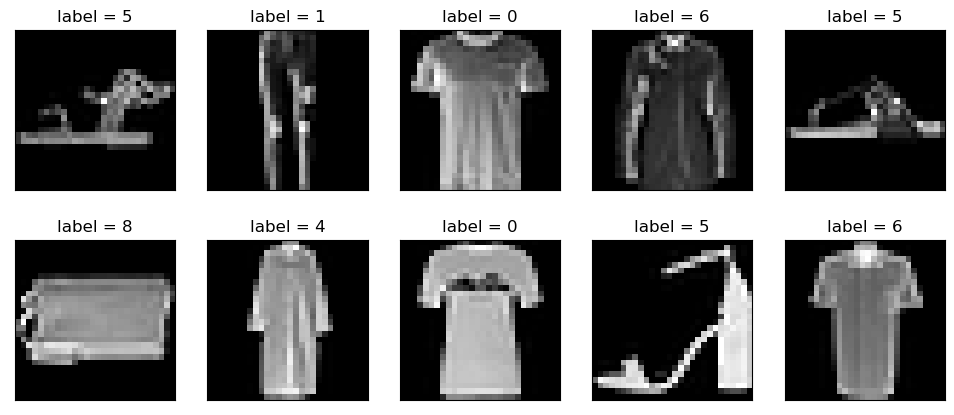

In [5]:
import random
from matplotlib import pyplot as plt
def denorm(img):
    for i in range(img.shape[0]):
        img[i] = img[i] * std[i] + mean[i]
    return img
plt.figure(figsize=(12, 5))
for i in range(10):
    img, label = train_dataset[random.randint(0, len(train_dataset))]
#     print(img.size())
#     img = denorm(img)
#     img = img.permute(1, 2, 0)
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze(0), cmap='gray', interpolation='none')
#     ax.imshow(img.numpy())
    ax.set_title("label = %d" % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


In [6]:
def U_TTN(params, wires):  # 2 params-------1√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_5(params, wires):  # 10 params-----------7√
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_6(params, wires):  # 10 params---------------8√
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_9(params, wires):  # 2 params-----------2√
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])


def U_13(params, wires):  # 6 params--------------4√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])


def U_14(params, wires):  # 6 params-------------5√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])


def U_15(params, wires):  # 4 params------------3√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_SO4(params, wires):  # 6 params------------6√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])


def U_SU4(params, wires):  # 15 params----------------9√
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])


# Pooling Layer 池化层

def Pooling_ansatz1(params, wires):  # 2 params
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])


def Pooling_ansatz2(wires):  # 0 params
    qml.CRZ(wires=[wires[0], wires[1]])


def Pooling_ansatz3(*params, wires):  # 3 params
    qml.CRot(*params, wires=[wires[0], wires[1]])

In [7]:
# Convolutional layers
def conv_layer1(U, params):
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])
    U(params, wires=[0, 7])

def conv_layer2(U, params):
    U(params, wires=[0, 2])
    U(params, wires=[4, 6])
    U(params, wires=[2, 4])
    U(params, wires=[0, 6])

# Pooling layers
def pooling_layer1(V, params):
    for i in range(0, 8, 2):
        V(params, wires=[i + 1, i])
        
def QCNN_structure(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 2 * U_params + 2]

    conv_layer1(U, param1)
    pooling_layer1(Pooling_ansatz1, param3)
    conv_layer2(U, param2)

In [8]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, params, U, U_params):

    AmplitudeEmbedding(q_input_features, wires=range(8), normalize=True)
        
    if U == 'U_TTN':
        QCNN_structure(U_TTN, params, U_params)
    elif U == 'U_5':
        QCNN_structure(U_5, params, U_params)
    elif U == 'U_6':
        QCNN_structure(U_6, params, U_params)
    elif U == 'U_9':
        QCNN_structure(U_9, params, U_params)
    elif U == 'U_13':
        QCNN_structure(U_13, params, U_params)
    elif U == 'U_14':
        QCNN_structure(U_14, params, U_params)
    elif U == 'U_15':
        QCNN_structure(U_15, params, U_params)
    elif U == 'U_SO4':
        QCNN_structure(U_SO4, params, U_params)
    elif U == 'U_SU4':
        QCNN_structure(U_SU4, params, U_params)   
    
    else:
        print("Invalid Unitary Ansatze")
        return False

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in [0, 2, 4, 6]]
    return exp_vals
    

In [9]:
class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()        
        self.flat_net = nn.Flatten()
        self.pre_net = nn.Linear(784, 256)
        self.q_params = nn.Parameter(q_delta * torch.randn(totol_params))
        self.post_net = nn.Linear(4, 10)  # 10分类

    def forward(self, input_features):
        input_features = self.flat_net(input_features)
        pre_out = self.pre_net(input_features)
        
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        
        q_out = torch.Tensor(0, 4)
        q_out = q_out.to(device)

        for elem in q_in:
            q_out_elem = torch.Tensor(quantum_net(elem, self.q_params, U, U_p)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        q_final = self.post_net(q_out)
        
        return q_final

In [10]:
model= DressedQuantumNet()

criterion = nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=step, weight_decay=0.0001)  # 减少过拟合

In [11]:
def train_model(model, criterion, optimizer, num_epochs):

    print("Training started:")

    best_acc = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        for i,(inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            # print(ret)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            y_true=[]
            y_pred=[]
            for j, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)

                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(predictions.cpu().numpy().tolist())

        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size

        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(model, 'Result/HQCCNN_Fashion-MNIST_10000.pth')


        epoch_end = time.time()

        print(
            "\t Training: Loss: {:.4f}, Accuracy: {:.4f}%, "
            "\n\t Validation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.3f}s".format(
                avg_train_loss, avg_train_acc * 100, avg_valid_loss, avg_valid_acc * 100,
                                epoch_end - epoch_start
            ))
        print("\t Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
        train_all_loss.append(avg_train_loss)
        train_all_acc.append(avg_train_acc)
        val_all_loss.append(avg_valid_loss)
        val_all_acc.append(avg_valid_acc)
        best_accuracy=best_acc

In [12]:
train_model(model, criterion, optimizer, num_epochs)

Training started:
Epoch: 1/50
	 Training: Loss: 1.6655, Accuracy: 52.2667%, 
	 Validation: Loss: 1.1732, Accuracy: 65.4500%, Time: 1319.663s
	 Best Accuracy for validation : 0.6545 at epoch 001
Epoch: 2/50
	 Training: Loss: 1.0257, Accuracy: 67.2833%, 
	 Validation: Loss: 0.9238, Accuracy: 68.1000%, Time: 1354.741s
	 Best Accuracy for validation : 0.6810 at epoch 002
Epoch: 3/50
	 Training: Loss: 0.8431, Accuracy: 70.8333%, 
	 Validation: Loss: 0.8050, Accuracy: 70.8500%, Time: 1323.490s
	 Best Accuracy for validation : 0.7085 at epoch 003
Epoch: 4/50
	 Training: Loss: 0.7515, Accuracy: 73.1167%, 
	 Validation: Loss: 0.7481, Accuracy: 69.7500%, Time: 1335.943s
	 Best Accuracy for validation : 0.7085 at epoch 003
Epoch: 5/50
	 Training: Loss: 0.6892, Accuracy: 74.2333%, 
	 Validation: Loss: 0.6897, Accuracy: 75.6500%, Time: 1344.499s
	 Best Accuracy for validation : 0.7565 at epoch 005
Epoch: 6/50
	 Training: Loss: 0.6462, Accuracy: 77.4333%, 
	 Validation: Loss: 0.6634, Accuracy: 77.60

	 Training: Loss: 0.2459, Accuracy: 92.2667%, 
	 Validation: Loss: 0.4538, Accuracy: 84.1000%, Time: 903.942s
	 Best Accuracy for validation : 0.8545 at epoch 025
Epoch: 49/50
	 Training: Loss: 0.2458, Accuracy: 92.1500%, 
	 Validation: Loss: 0.4448, Accuracy: 84.3500%, Time: 904.227s
	 Best Accuracy for validation : 0.8545 at epoch 025
Epoch: 50/50
	 Training: Loss: 0.2582, Accuracy: 91.6833%, 
	 Validation: Loss: 0.4574, Accuracy: 84.1500%, Time: 900.938s
	 Best Accuracy for validation : 0.8545 at epoch 025


In [13]:
print(train_all_loss)
print(train_all_acc)
print(val_all_loss)
print(val_all_acc)


[1.665521183013916, 1.0257362270355224, 0.8430974337259929, 0.7514805075327555, 0.6891647166411082, 0.6462073492209116, 0.6066805497805278, 0.5675647721290589, 0.5218466855684916, 0.4862496661345164, 0.46052114272117617, 0.439852624018987, 0.4196079982916514, 0.4029664259751638, 0.3962772445678711, 0.37799072329203287, 0.36780275575319926, 0.36254378537336984, 0.35255603249867756, 0.34516377027829487, 0.3447720606327057, 0.34326804741223654, 0.32859994180997215, 0.3138159209092458, 0.3163094528516134, 0.31290006045500435, 0.30557621296246845, 0.30389477507273355, 0.2961399755080541, 0.2899386016527812, 0.28481180787086485, 0.28208358502388, 0.2775517613887787, 0.27566811990737916, 0.27750876907507577, 0.27996682476997375, 0.2799581191937129, 0.2569213434855143, 0.2895033198197683, 0.27591254842281343, 0.2559866916338603, 0.2625649842818578, 0.24994948661327362, 0.24492054458459217, 0.24501412093639374, 0.2590239917039871, 0.2522851105133692, 0.24591200850407283, 0.24577865207195282, 0.

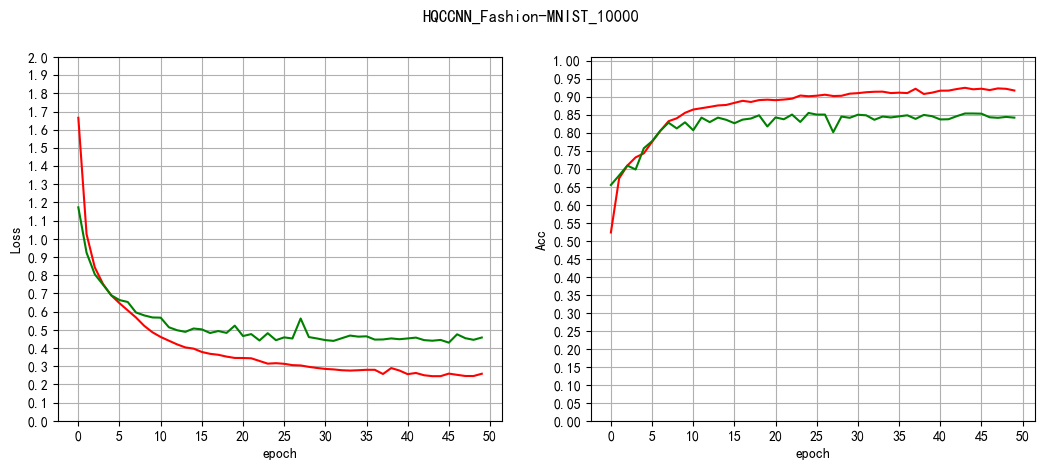

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

x = np.arange(0, 50)

width, height = 32, 12 
fig = plt.figure()
fig.suptitle("HQCCNN_Fashion-MNIST_10000", fontsize=12)

fig.set_size_inches(width / 2.54, height / 2.54)

plt.subplot(1, 2, 1)  # fig.1是一个一行两列布局的图，且现在画的是左图
loss_1 = train_all_loss
loss_2 = val_all_loss
line1, = plt.plot(x, loss_1, color='r')
line2, = plt.plot(x, loss_2, color='g')
# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Loss")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0, 2.0001, 0.1))
plt.ylim(0, 2)


plt.subplot(1, 2, 2)  # 当前图变为fig.1的右图
acc_1 = train_all_acc
acc_2 = val_all_acc

line1, = plt.plot(x, acc_1, color='r')
line2, = plt.plot(x, acc_2, color='g')

# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Acc")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0.0, 1.01, 0.05))
plt.ylim(0.0, 1.01)

plt.show()


In [15]:
model_Q = DressedQuantumNet()
model_Q = torch.load('Result/HQCCNN_Fashion-MNIST_10000.pth', map_location=device)
model_Q.eval()

DressedQuantumNet(
  (flat_net): Flatten(start_dim=1, end_dim=-1)
  (pre_net): Linear(in_features=784, out_features=256, bias=True)
  (post_net): Linear(in_features=4, out_features=10, bias=True)
)

In [16]:
print('HQCCNN_Fashion-MNIST_10000')

totel_acc=0.0

for j, (inputs, labels) in enumerate(test_dataloader):
    outputs = model_Q(inputs)
    ret, predictions = torch.max(outputs.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    totel_acc += acc.item() * inputs.size(0)
print('测试集2000：')
print(totel_acc/test_data_size)

HQCCNN_Fashion-MNIST_10000
测试集2000：
0.8485
